In [37]:
import os
import pandas as pd


In [38]:
ppg_directory = 'PPGCSV'
ground_truth = 'groundtruth.csv'

df_groundtruth = pd.read_csv(ground_truth)
display(df_groundtruth.head())
print('PPG Data loaded')

,ID,Gender,Age [years],Height [cm],Weight [kg],Ear/finger,Motion,Blood pressure [mmHg],Glycaemia [mmol/l],SpO2 [%],Quality,HR
0,100001,F,51,NaN,58,1,0,NaN,NaN,NaN,1,83
1,100002,F,51,NaN,58,1,0,NaN,NaN,NaN,1,85
2,100003,F,51,NaN,58,1,0,NaN,NaN,NaN,1,81
3,100004,F,51,NaN,58,1,2;3,NaN,NaN,NaN,0,85
4,101001,F,54,NaN,63,1,0,NaN,NaN,NaN,1,67


PPG Data loaded


In [39]:
# Check the data types of each column
print(df_groundtruth.dtypes)


ID                         int64
Gender                    object
Age [years]                int64
Height [cm]              float64
Weight [kg]                int64
Ear/finger                 int64
Motion                    object
Blood pressure [mmHg]     object
Glycaemia [mmol/l]       float64
SpO2 [%]                 float64
Quality                    int64
HR                         int64
dtype: object


In [40]:
# Convert columns to appropriate data types
df_groundtruth["Quality"] = pd.to_numeric(df_groundtruth["Quality"], errors="coerce").fillna(0).astype(int)
df_groundtruth["Motion"] = pd.to_numeric(df_groundtruth["Motion"], errors="coerce").fillna(0).astype(int)
df_groundtruth["Ear/finger"] = pd.to_numeric(df_groundtruth["Ear/finger"], errors="coerce").fillna(0).astype(int)
df_groundtruth["HR"] = pd.to_numeric(df_groundtruth["HR"], errors="coerce").fillna(0)  # Heart rate
df_groundtruth["SpO2 [%]"] = pd.to_numeric(df_groundtruth["SpO2 [%]"], errors="coerce").fillna(0)  # SpO₂


In [41]:
# Filter for high-quality, motion-free, and finger/ear segments
df_filtered = df_groundtruth[
    (df_groundtruth["Quality"] == 1) &
    (df_groundtruth["Motion"] == 0) &
    (df_groundtruth["Ear/finger"] == 1)
]

# Display the filtered DataFrame
print("Filtered DataFrame (High-Quality PPG):")
display(df_filtered.tail())


Filtered DataFrame (High-Quality PPG):


,ID,Gender,Age [years],Height [cm],Weight [kg],Ear/finger,Motion,Blood pressure [mmHg],Glycaemia [mmol/l],SpO2 [%],Quality,HR
3883,149104,F,52,154.0,60,1,0,107/66,10.2,96.0,1,80
3884,149105,F,52,154.0,60,1,0,107/66,10.2,97.0,1,81
3885,149106,F,52,154.0,60,1,0,107/66,10.2,96.0,1,80
3886,149107,F,52,154.0,60,1,0,107/66,10.2,97.0,1,81
3887,149108,F,52,154.0,60,1,0,107/66,10.2,97.0,1,80


In [42]:
# Check the number of valid rows
print(f"Number of valid PPG segments: {len(df_filtered)}")

# Verify data types
print("Filtered Data Types:")
print(df_filtered.dtypes)


Number of valid PPG segments: 478
Filtered Data Types:
ID                         int64
Gender                    object
Age [years]                int64
Height [cm]              float64
Weight [kg]                int64
Ear/finger                 int32
Motion                     int32
Blood pressure [mmHg]     object
Glycaemia [mmol/l]       float64
SpO2 [%]                 float64
Quality                    int32
HR                         int64
dtype: object


In [43]:
import os
import pandas as pd

def load_ppg_csv(segment_id, folder_path):
    """
    Loads a PPG CSV file based on the segment ID.

    Parameters:
        segment_id (str): The segment ID (e.g., '111001').
        folder_path (str): Path to the folder containing PPG CSV files.

    Returns:
        pd.DataFrame: DataFrame containing the PPG signal (Time, PPGG).
    """
    file_path = os.path.join(folder_path, f"{segment_id}.csv")
    
    if not os.path.exists(file_path):
        print(f"⚠️ Warning: File not found for segment ID: {segment_id}")
        return None

    try:
        # Load the CSV file
        df = pd.read_csv(file_path)
        return df
    except Exception as e:
        print(f"⚠️ Error loading file {file_path}: {e}")
        return None


In [44]:
# Initialize a list to store PPG data
ppg_data = []

# Iterate through filtered segments
for index, row in df_filtered.iterrows():
    segment_id = row["ID"]  # The unique segment ID
    ppg_df = load_ppg_csv(segment_id, ppg_directory)  # Load the PPG CSV

    if ppg_df is not None:
        # Add the PPG signal along with metadata (e.g., HR, SpO₂)
        ppg_df["HR"] = row["HR"]  # Add the heart rate from groundtruth
        ppg_df["Glycaemia"] = row["Glycaemia [mmol/l]"]  # Add glycaemia from groundtruth
        ppg_df["Blood pressure"] = row["Blood pressure [mmHg]"]  # Add blood pressure from groundtruth
        ppg_df["SpO2"] = row["SpO2 [%]"]  # Add SpO₂ from groundtruth
        ppg_df["Segment ID"] = segment_id  # Track the segment ID
        ppg_data.append(ppg_df)

# Combine all PPG data into a single DataFrame
df_ppg = pd.concat(ppg_data, ignore_index=True)

# Split 'Blood pressure' into 'Systolic' and 'Diastolic'
df_ppg[["Systolic", "Diastolic"]] = df_ppg["Blood pressure"].str.split("/", expand=True)

# Convert 'Systolic' and 'Diastolic' to numeric
df_ppg["Systolic"] = pd.to_numeric(df_ppg["Systolic"], errors="coerce")
df_ppg["Diastolic"] = pd.to_numeric(df_ppg["Diastolic"], errors="coerce")

# Drop the original 'Blood pressure' column (optional)
df_ppg.drop(columns=["Blood pressure"], inplace=True)

# Display the updated DataFrame
print("Combined PPG DataFrame with Systolic and Diastolic:")
display(df_ppg.head())


⚠️ Warning: File not found for segment ID: 100001
⚠️ Warning: File not found for segment ID: 100002
⚠️ Warning: File not found for segment ID: 100003
⚠️ Warning: File not found for segment ID: 101001
⚠️ Warning: File not found for segment ID: 101002
⚠️ Warning: File not found for segment ID: 101003
⚠️ Warning: File not found for segment ID: 102001
⚠️ Warning: File not found for segment ID: 102002
⚠️ Warning: File not found for segment ID: 102003
⚠️ Warning: File not found for segment ID: 102004
⚠️ Warning: File not found for segment ID: 103002
⚠️ Warning: File not found for segment ID: 103003
⚠️ Warning: File not found for segment ID: 104001
⚠️ Warning: File not found for segment ID: 104002
⚠️ Warning: File not found for segment ID: 104003
⚠️ Warning: File not found for segment ID: 105001
⚠️ Warning: File not found for segment ID: 105002
⚠️ Warning: File not found for segment ID: 105003
⚠️ Warning: File not found for segment ID: 106001
⚠️ Warning: File not found for segment ID: 106002


,Time (s),PPGG,HR,Glycaemia,SpO2,Segment ID,Systolic,Diastolic
0,0.000000,2.288472e+08,77,6.9,99.0,132004,101,65
1,0.033333,2.387843e+08,77,6.9,99.0,132004,101,65
2,0.066667,3.400156e+08,77,6.9,99.0,132004,101,65
3,0.100000,3.571975e+08,77,6.9,99.0,132004,101,65
4,0.133333,4.197082e+08,77,6.9,99.0,132004,101,65


In [45]:
import pandas as pd

# Group by Segment ID and aggregate
ppg_grouped = df_ppg.groupby("Segment ID").agg({
    "PPGG": list,         # Collect all PPGG values into a list
    "HR": "first",         # Take the first (constant) HR value for the segment
    "SpO2" : "first",
    "Glycaemia" : "first",
    "Systolic":"first",
    "Diastolic": "first"
}).reset_index()

# Rename columns to match desired format
ppg_grouped.rename(columns={"PPGG": "PPG_SIGNAL"}, inplace=True)

# Display the transformed DataFrame
print("Transformed PPG DataFrame:")
display(ppg_grouped.head())

# Save to a CSV file if needed
ppg_grouped.to_csv("transformed_ppg_data.csv", index=False)


Transformed PPG DataFrame:


,Segment ID,PPG_SIGNAL,HR,SpO2,Glycaemia,Systolic,Diastolic
0,132004,"[228847219.5075, 238784328.7182, 340015569.347...",77,99.0,6.9,101,65
1,132005,"[743662069.948, 733520310.6899999, 736382094.2...",75,98.0,6.9,101,65
2,132006,"[-305872512.4, -310000110.6992, -316695693.608...",73,98.0,6.9,101,65
3,132008,"[-834906497.436, -945382102.8168, -1061351904....",73,98.0,6.9,101,65
4,132009,"[-84126148.1368, -94588051.0212, -86687758.225...",81,99.0,6.9,101,65


In [46]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.signal import find_peaks
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, BatchNormalization, MaxPooling1D, Dropout

# 1. Data Preprocessing
def preprocess_data(df):
    # Convert string PPG signals to numpy arrays
    df['PPG_SIGNAL'] = df['PPG_SIGNAL'].apply(lambda x: np.array(eval(x)))
    
    # Normalize PPG signals using Z-score normalization
    def normalize_ppg(signal):
        return (signal - np.mean(signal)) / np.std(signal)
    
    df['PPG_SIGNAL_NORMALIZED'] = df['PPG_SIGNAL'].apply(normalize_ppg)
    
    # Normalize vital signs using Min-Max scaling
    vital_signs = ['HR', 'SpO2', 'Glycaemia', 'Systolic', 'Diastolic']
    scaler = MinMaxScaler()
    df[vital_signs] = scaler.fit_transform(df[vital_signs])
    
    return df, scaler

# 2. Feature Engineering
def extract_features(ppg_signal):
    # Find peaks
    peaks, _ = find_peaks(ppg_signal, distance=10)
    
    # Calculate features
    features = {
        'mean': np.mean(ppg_signal),
        'std': np.std(ppg_signal),
        'peak_count': len(peaks),
        'peak_mean': np.mean(ppg_signal[peaks]) if len(peaks) > 0 else 0,
        'peak_std': np.std(ppg_signal[peaks]) if len(peaks) > 0 else 0,
    }
    
    # Add first derivative
    first_derivative = np.diff(ppg_signal)
    features['first_derivative_mean'] = np.mean(first_derivative)
    features['first_derivative_std'] = np.std(first_derivative)
    
    return features

def prepare_model_inputs(df):
    # Prepare X (features)
    X = np.stack(df['PPG_SIGNAL_NORMALIZED'].values)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape for CNN input
    
    return X

# 3. Model Architecture
def create_model(input_shape, output_size=1):
    model = Sequential([
        # 1D CNN layers
        Conv1D(64, kernel_size=5, padding='same', input_shape=input_shape),
        BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        MaxPooling1D(2),
        
        Conv1D(128, kernel_size=3, padding='same'),
        BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        MaxPooling1D(2),
        
        # LSTM layers
        LSTM(100, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        
        # Dense layers
        Dense(50, activation='relu'),
        Dense(output_size)
    ])
    
    return model

# 4. Training Setup
def prepare_training(model, learning_rate=1e-3):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae', 'mse']
    )
    
    # Define callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
    ]
    
    return callbacks


In [47]:
import pandas as pd

# Load your dataset (update with your file path)
df = pd.read_csv("transformed_ppg_data.csv")

# Display the first few rows
print(df.head())


   Segment ID                                         PPG_SIGNAL  HR  SpO2  \
0      132004  [228847219.5075, 238784328.7182, 340015569.347...  77  99.0   
1      132005  [743662069.948, 733520310.6899999, 736382094.2...  75  98.0   
2      132006  [-305872512.4, -310000110.6992, -316695693.608...  73  98.0   
3      132008  [-834906497.436, -945382102.8168, -1061351904....  73  98.0   
4      132009  [-84126148.1368, -94588051.0212, -86687758.225...  81  99.0   

   Glycaemia  Systolic  Diastolic  
0        6.9       101         65  
1        6.9       101         65  
2        6.9       101         65  
3        6.9       101         65  
4        6.9       101         65  


In [48]:
import pandas as pd
import numpy as np
from scipy import stats

def check_data_quality(df):
    print("=== Data Quality Report ===\n")
    
    # 1. Basic DataFrame Information
    print("1. Basic Information:")
    print(f"Total number of records: {len(df)}")
    print(f"Number of features: {len(df.columns)}")
    print("\nColumns:", list(df.columns))
    
    # 2. Check for missing values
    print("\n2. Missing Values:")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])
    
    # 3. Vital Signs Analysis
    vital_signs = ['HR', 'SpO2', 'Glycaemia', 'Systolic', 'Diastolic']
    print("\n3. Vital Signs Statistics:")
    for vital in vital_signs:
        stats_dict = {
            'min': df[vital].min(),
            'max': df[vital].max(),
            'mean': df[vital].mean(),
            'std': df[vital].std(),
            'unique_values': df[vital].nunique()
        }
        print(f"\n{vital}:")
        for stat, value in stats_dict.items():
            print(f"  {stat}: {value:.2f}")
            
        # Check for physiologically implausible values
        is_plausible = check_vital_sign_plausibility(df[vital], vital)
        print(f"  Potentially implausible values: {not is_plausible}")
    
    # 4. PPG Signal Analysis
    print("\n4. PPG Signal Quality:")
    ppg_stats = analyze_ppg_signals(df)
    print(ppg_stats)
    
    # 5. Check for duplicates
    print("\n5. Duplicate Analysis:")
    duplicates = df.duplicated().sum()
    print(f"Number of duplicate rows: {duplicates}")
    
    return missing_values, ppg_stats

def check_vital_sign_plausibility(series, vital_type):
    plausible_ranges = {
        'HR': (30, 200),     # beats per minute
        'SpO2': (70, 100),   # percentage
        'Glycaemia': (2, 25), # mmol/l
        'Systolic': (70, 200), # mmHg
        'Diastolic': (40, 130) # mmHg
    }
    
    if vital_type in plausible_ranges:
        min_val, max_val = plausible_ranges[vital_type]
        return series.between(min_val, max_val).all()
    return True

def analyze_ppg_signals(df):
    # Convert string representation of PPG signals to numpy arrays
    ppg_signals = df['PPG_SIGNAL'].apply(lambda x: np.array(eval(x)))
    
    # Calculate basic statistics for each PPG signal
    signal_lengths = ppg_signals.apply(len)
    signal_means = ppg_signals.apply(np.mean)
    signal_stds = ppg_signals.apply(np.std)
    
    stats = {
        'Unique signal lengths': signal_lengths.unique().tolist(),
        'Mean signal length': signal_lengths.mean(),
        'Min signal mean': signal_means.min(),
        'Max signal mean': signal_means.max(),
        'Min signal std': signal_stds.min(),
        'Max signal std': signal_stds.max()
    }
    
    # Check for zero-variance signals (potential flatlines)
    zero_variance = (signal_stds == 0).sum()
    stats['Number of flatline signals'] = zero_variance
    
    return stats

# Run the data quality check
missing_values, ppg_stats = check_data_quality(df)



=== Data Quality Report ===

1. Basic Information:
Total number of records: 443
Number of features: 7

Columns: ['Segment ID', 'PPG_SIGNAL', 'HR', 'SpO2', 'Glycaemia', 'Systolic', 'Diastolic']

2. Missing Values:
Series([], dtype: int64)

3. Vital Signs Statistics:

HR:
  min: 53.00
  max: 117.00
  mean: 73.84
  std: 11.11
  unique_values: 50.00
  Potentially implausible values: False

SpO2:
  min: 86.00
  max: 99.00
  mean: 97.04
  std: 1.44
  unique_values: 10.00
  Potentially implausible values: False

Glycaemia:
  min: 3.70
  max: 13.40
  mean: 6.07
  std: 2.00
  unique_values: 21.00
  Potentially implausible values: False

Systolic:
  min: 89.00
  max: 153.00
  mean: 124.58
  std: 14.89
  unique_values: 28.00
  Potentially implausible values: False

Diastolic:
  min: 57.00
  max: 91.00
  mean: 74.48
  std: 7.51
  unique_values: 19.00
  Potentially implausible values: False

4. PPG Signal Quality:
{'Unique signal lengths': [300], 'Mean signal length': 300.0, 'Min signal mean': -787

In [49]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

def normalize_dataset(df):
    """
    Normalize both PPG signals and vital signs.
    
    Args:
        df: DataFrame with columns ['PPG_SIGNAL', 'HR', 'SpO2', 'Glycaemia', 'Systolic', 'Diastolic']
    
    Returns:
        normalized_df: DataFrame with normalized values
        vital_signs_scaler: fitted MinMaxScaler for vital signs
    """
    # 1. Normalize PPG signals using Z-score normalization
    def normalize_ppg(signal_str):
        # Convert string representation to numpy array
        signal = np.array(eval(signal_str))
        # Apply Z-score normalization
        normalized = (signal - np.mean(signal)) / np.std(signal)
        return normalized.tolist()  # Convert back to list for storage
    
    # Create copy of dataframe to avoid modifying original
    normalized_df = df.copy()
    
    # Normalize PPG signals
    normalized_df['PPG_SIGNAL_NORMALIZED'] = normalized_df['PPG_SIGNAL'].apply(normalize_ppg)
    
    # 2. Normalize vital signs using Min-Max scaling
    vital_signs = ['HR', 'SpO2', 'Glycaemia', 'Systolic', 'Diastolic']
    vital_signs_scaler = MinMaxScaler()
    
    # Fit and transform vital signs
    normalized_df[vital_signs] = vital_signs_scaler.fit_transform(normalized_df[vital_signs])
    
    # 3. Verify normalization
    def verify_ppg_normalization(signal):
        arr = np.array(signal)
        return {
            'mean': np.mean(arr),
            'std': np.std(arr),
            'min': np.min(arr),
            'max': np.max(arr)
        }
    
    # Calculate statistics for verification
    ppg_stats = normalized_df['PPG_SIGNAL_NORMALIZED'].apply(verify_ppg_normalization)
    
    print("=== Normalization Verification ===")
    print("\nPPG Signal Statistics (should be ~0 mean and ~1 std):")
    means = [stat['mean'] for stat in ppg_stats]
    stds = [stat['std'] for stat in ppg_stats]
    print(f"Mean of means: {np.mean(means):.6f}")
    print(f"Mean of stds: {np.mean(stds):.6f}")
    
    print("\nVital Signs Range (should be 0-1):")
    for col in vital_signs:
        print(f"{col}: {normalized_df[col].min():.6f} to {normalized_df[col].max():.6f}")
    
    return normalized_df, vital_signs_scaler

# Example usage:

# Assuming your DataFrame is loaded
normalized_df, vital_signs_scaler = normalize_dataset(df)

# Save normalized data if needed
normalized_df.to_csv('normalized_ppg_data.csv', index=False)

# # To inverse transform vital signs later if needed:
# original_values = vital_signs_scaler.inverse_transform(normalized_values)


=== Normalization Verification ===

PPG Signal Statistics (should be ~0 mean and ~1 std):
Mean of means: -0.000000
Mean of stds: 1.000000

Vital Signs Range (should be 0-1):
HR: 0.000000 to 1.000000
SpO2: 0.000000 to 1.000000
Glycaemia: 0.000000 to 1.000000
Systolic: 0.000000 to 1.000000
Diastolic: 0.000000 to 1.000000


In [50]:
# Load your data
df = pd.read_csv('normalized_ppg_data.csv')  # or your current DataFrame

# Apply normalization
normalized_df, vital_signs_scaler = normalize_dataset(df)

# Save normalized data if needed
normalized_df.to_csv('normalized_ppg_data.csv', index=False)

=== Normalization Verification ===

PPG Signal Statistics (should be ~0 mean and ~1 std):
Mean of means: -0.000000
Mean of stds: 1.000000

Vital Signs Range (should be 0-1):
HR: 0.000000 to 1.000000
SpO2: 0.000000 to 1.000000
Glycaemia: 0.000000 to 1.000000
Systolic: 0.000000 to 1.000000
Diastolic: 0.000000 to 1.000000


In [51]:
import numpy as np
from scipy.signal import find_peaks, butter, filtfilt
from scipy.fft import fft
import pandas as pd

def extract_features(ppg_signal):
    """
    Extract comprehensive features from a PPG signal.
    
    Args:
        ppg_signal: numpy array of normalized PPG values
        
    Returns:
        dict: Dictionary containing all extracted features
    """
    features = {}
    
    # 1. Time Domain Statistical Features
    features.update(extract_statistical_features(ppg_signal))
    
    # 2. Peak-Related Features
    features.update(extract_peak_features(ppg_signal))
    
    # 3. Frequency Domain Features
    features.update(extract_frequency_features(ppg_signal))
    
    # 4. Derivative Features
    features.update(extract_derivative_features(ppg_signal))
    
    return features

def extract_statistical_features(signal):
    """Extract basic statistical features."""
    return {
        'mean': np.mean(signal),
        'std': np.std(signal),
        'skewness': float(pd.Series(signal).skew()),
        'kurtosis': float(pd.Series(signal).kurtosis()),
        'rms': np.sqrt(np.mean(np.square(signal))),
        'peak_to_peak': np.max(signal) - np.min(signal)
    }

def extract_peak_features(signal, sampling_rate=30):
    """Extract features related to peaks and valleys."""
    # Find peaks
    peaks, _ = find_peaks(signal, distance=sampling_rate//3)  # Minimum distance between peaks
    valleys, _ = find_peaks(-signal, distance=sampling_rate//3)
    
    if len(peaks) < 2 or len(valleys) < 2:
        return {
            'mean_peak_height': 0,
            'std_peak_height': 0,
            'mean_peak_distance': 0,
            'std_peak_distance': 0,
            'mean_valley_depth': 0,
            'std_valley_depth': 0
        }
    
    peak_heights = signal[peaks]
    valley_depths = signal[valleys]
    peak_distances = np.diff(peaks) / sampling_rate  # Convert to seconds
    
    return {
        'mean_peak_height': np.mean(peak_heights),
        'std_peak_height': np.std(peak_heights),
        'mean_peak_distance': np.mean(peak_distances),
        'std_peak_distance': np.std(peak_distances),
        'mean_valley_depth': np.mean(valley_depths),
        'std_valley_depth': np.std(valley_depths)
    }

def extract_frequency_features(signal, sampling_rate=30):
    """Extract frequency domain features."""
    # Compute FFT
    n = len(signal)
    fft_values = fft(signal)
    frequencies = np.fft.fftfreq(n, 1/sampling_rate)
    
    # Consider only positive frequencies and their magnitudes
    pos_freq_idx = frequencies > 0
    frequencies = frequencies[pos_freq_idx]
    magnitudes = np.abs(fft_values[pos_freq_idx])
    
    # Find dominant frequencies
    sorted_idx = np.argsort(magnitudes)[::-1]
    dominant_freqs = frequencies[sorted_idx[:3]]
    dominant_mags = magnitudes[sorted_idx[:3]]
    
    return {
        'dominant_freq_1': dominant_freqs[0] if len(dominant_freqs) > 0 else 0,
        'dominant_freq_2': dominant_freqs[1] if len(dominant_freqs) > 1 else 0,
        'dominant_freq_3': dominant_freqs[2] if len(dominant_freqs) > 2 else 0,
        'dominant_magnitude_1': dominant_mags[0] if len(dominant_mags) > 0 else 0,
        'dominant_magnitude_2': dominant_mags[1] if len(dominant_mags) > 1 else 0,
        'dominant_magnitude_3': dominant_mags[2] if len(dominant_mags) > 2 else 0
    }

def extract_derivative_features(signal):
    """Extract features based on signal derivatives."""
    # First derivative (velocity)
    first_derivative = np.diff(signal)
    
    # Second derivative (acceleration)
    second_derivative = np.diff(first_derivative)
    
    return {
        'mean_velocity': np.mean(first_derivative),
        'std_velocity': np.std(first_derivative),
        'max_velocity': np.max(np.abs(first_derivative)),
        'mean_acceleration': np.mean(second_derivative),
        'std_acceleration': np.std(second_derivative),
        'max_acceleration': np.max(np.abs(second_derivative))
    }

def process_all_signals(df):
    """
    Process all PPG signals in the dataset and extract features.
    
    Args:
        df: DataFrame with 'PPG_SIGNAL_NORMALIZED' column
        
    Returns:
        DataFrame with extracted features
    """
    # Convert string representation of PPG signals to numpy arrays if needed
    if isinstance(df['PPG_SIGNAL_NORMALIZED'].iloc[0], str):
        df['PPG_SIGNAL_NORMALIZED'] = df['PPG_SIGNAL_NORMALIZED'].apply(eval)
    
    # Extract features for each signal
    all_features = []
    for idx, row in df.iterrows():
        features = extract_features(np.array(row['PPG_SIGNAL_NORMALIZED']))
        features['Segment_ID'] = row.get('Segment ID', idx)
        all_features.append(features)
    
    # Create features DataFrame
    features_df = pd.DataFrame(all_features)
    
    # Add target variables if they exist in original DataFrame
    target_columns = ['HR', 'SpO2', 'Glycaemia', 'Systolic', 'Diastolic']
    for col in target_columns:
        if col in df.columns:
            features_df[col] = df[col]
    
    return features_df

# Example usage:

# Assuming you have your normalized DataFrame
# normalized_df = ...

# Extract features
features_df = process_all_signals(normalized_df)

# Save features if needed
features_df.to_csv('ppg_featuresEx.csv', index=False)


In [52]:
print(features_df.columns)
print(features_df.head())

Index(['mean', 'std', 'skewness', 'kurtosis', 'rms', 'peak_to_peak',
       'mean_peak_height', 'std_peak_height', 'mean_peak_distance',
       'std_peak_distance', 'mean_valley_depth', 'std_valley_depth',
       'dominant_freq_1', 'dominant_freq_2', 'dominant_freq_3',
       'dominant_magnitude_1', 'dominant_magnitude_2', 'dominant_magnitude_3',
       'mean_velocity', 'std_velocity', 'max_velocity', 'mean_acceleration',
       'std_acceleration', 'max_acceleration', 'Segment_ID', 'HR', 'SpO2',
       'Glycaemia', 'Systolic', 'Diastolic'],
      dtype='object')
           mean  std  skewness  kurtosis  rms  peak_to_peak  mean_peak_height  \
0  4.736952e-17  1.0 -0.991351  0.486164  1.0      4.632625          0.243037   
1 -9.473903e-17  1.0  0.023495 -1.540256  1.0      3.087958          0.233386   
2 -9.473903e-17  1.0 -0.841649 -1.139713  1.0      2.866305          0.289123   
3  4.736952e-17  1.0 -0.183057 -0.715492  1.0      4.280208          0.470201   
4  4.736952e-17  1.0  0.24

In [53]:
features_df = process_all_signals(normalized_df)

In [54]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.signal import find_peaks
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, BatchNormalization, MaxPooling1D, Dropout, concatenate, LeakyReLU

In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# Load both datasets
df_original = pd.read_csv('transformed_ppg_data.csv')  # For raw PPG signals
df_features = pd.read_csv('ppg_features.csv')          # For engineered features

# Quick verification
print("Original data shape:", df_original.shape)
print("Features data shape:", df_features.shape)

# Display first few columns of each
print("\nOriginal data columns:", df_original.columns.tolist())
print("\nFeatures data columns:", df_features.columns.tolist())

Original data shape: (443, 7)
Features data shape: (443, 12)

Original data columns: ['Segment ID', 'PPG_SIGNAL', 'HR', 'SpO2', 'Glycaemia', 'Systolic', 'Diastolic']

Features data columns: ['mean', 'std', 'skewness', 'kurtosis', 'rms', 'mad', 'dominant_freq', 'total_power', 'mean_ibi', 'ibi_std', 'mean_peak_amp', 'HR']


In [56]:
# 1. Prepare data for training
def prepare_model_data(df_original, df_features, target='HR'):
    # Prepare PPG signals
    ppg_signals = np.array([eval(signal) for signal in df_original['PPG_SIGNAL']])
    
    # Normalize each PPG signal
    normalized_ppg = np.array([
        (signal - np.mean(signal)) / np.std(signal)
        for signal in ppg_signals
    ])
    
    # Reshape for CNN input (samples, timesteps, features)
    normalized_ppg = normalized_ppg.reshape(-1, normalized_ppg.shape[1], 1)
    
    # Prepare engineered features (exclude target column)
    feature_columns = [col for col in df_features.columns if col != target]
    feature_scaler = StandardScaler()
    engineered_features = feature_scaler.fit_transform(df_features[feature_columns])
    
    # Prepare target variable
    target_scaler = StandardScaler()
    targets = target_scaler.fit_transform(df_original[[target]])
    
    print("Shapes:")
    print(f"PPG signals: {normalized_ppg.shape}")
    print(f"Engineered features: {engineered_features.shape}")
    print(f"Targets: {targets.shape}")
    
    return {
        'ppg_signals': normalized_ppg,
        'engineered_features': engineered_features,
        'targets': targets.reshape(-1),
        'feature_scaler': feature_scaler,
        'target_scaler': target_scaler
    }

# Prepare the data
prepared_data = prepare_model_data(df_original, df_features, target='HR')

Shapes:
PPG signals: (443, 300, 1)
Engineered features: (443, 11)
Targets: (443, 1)


In [57]:
def create_hybrid_model(sequence_length, n_engineered_features):
    # PPG signal input
    ppg_input = Input(shape=(sequence_length, 1), name='ppg_input')
    
    # CNN layers
    x = Conv1D(64, kernel_size=5, padding='same')(ppg_input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2)(x)
    
    x = Conv1D(128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2)(x)
    
    # LSTM layers
    x = LSTM(100, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(50)(x)
    x = Dropout(0.2)(x)
    
    # Engineered features input
    engineered_input = Input(shape=(n_engineered_features,), name='engineered_input')
    engineered_x = Dense(32, activation='relu')(engineered_input)
    engineered_x = BatchNormalization()(engineered_x)
    engineered_x = Dropout(0.2)(engineered_x)
    
    # Combine both branches
    combined = concatenate([x, engineered_x])
    
    # Final dense layers
    x = Dense(64, activation='relu')(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    output = Dense(1)(x)
    
    model = Model(inputs=[ppg_input, engineered_input], outputs=output)
    return model

# Create model
model = create_hybrid_model(
    sequence_length=300,  # Your PPG signal length
    n_engineered_features=len(df_features.columns) - 1  # Number of features excluding target
)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Display model summary
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ppg_input (InputLayer)         [(None, 300, 1)]     0           []                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 300, 64)      384         ['ppg_input[0][0]']              
                                                                                                  
 batch_normalization_13 (BatchN  (None, 300, 64)     256         ['conv1d_6[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 leaky_re_lu_6 (LeakyReLU)      (None, 300, 64)      0           ['batch_normalization_13[0]

In [58]:
from sklearn.model_selection import train_test_split

# Split data into train+validation and test sets (80/20)
train_val_indices, test_indices = train_test_split(
    np.arange(len(prepared_data['targets'])),
    test_size=0.2,
    random_state=42
)

# Split train+validation into train and validation sets (80/20 of remaining)
train_indices, val_indices = train_test_split(
    train_val_indices,
    test_size=0.2,
    random_state=42
)

# Prepare data splits
train_data = {
    'ppg_signals': prepared_data['ppg_signals'][train_indices],
    'engineered_features': prepared_data['engineered_features'][train_indices],
    'targets': prepared_data['targets'][train_indices]
}

val_data = {
    'ppg_signals': prepared_data['ppg_signals'][val_indices],
    'engineered_features': prepared_data['engineered_features'][val_indices],
    'targets': prepared_data['targets'][val_indices]
}

test_data = {
    'ppg_signals': prepared_data['ppg_signals'][test_indices],
    'engineered_features': prepared_data['engineered_features'][test_indices],
    'targets': prepared_data['targets'][test_indices]
}

# Setup callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

# Train the model
history = model.fit(
    [train_data['ppg_signals'], train_data['engineered_features']],
    train_data['targets'],
    validation_data=(
        [val_data['ppg_signals'], val_data['engineered_features']],
        val_data['targets']
    ),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
9/9 [==============================] - 3s 96ms/step - loss: 2.3343 - mae: 1.2580 - val_loss: 0.8332 - val_mae: 0.7658 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 0s 27ms/step - loss: 1.4135 - mae: 0.9762 - val_loss: 0.7386 - val_mae: 0.7294 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - 0s 24ms/step - loss: 1.2010 - mae: 0.8684 - val_loss: 0.6737 - val_mae: 0.6837 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - 0s 17ms/step - loss: 1.2545 - mae: 0.8632 - val_loss: 0.6870 - val_mae: 0.7152 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - 0s 18ms/step - loss: 1.1961 - mae: 0.8645 - val_loss: 0.7082 - val_mae: 0.7228 - lr: 0.0010
Epoch 6/100
9/9 [==============================] - 0s 17ms/step - loss: 1.1042 - mae: 0.8302 - val_loss: 0.6959 - val_mae: 0.7000 - lr: 0.0010
Epoch 7/100
9/9 [==============================] - 0s 29ms/step - loss: 0.9261 - mae: 0.7645 - val_loss: 0.6607 - val_mae: 0.6916 - lr: 0.0010

In [59]:
# Evaluate on test set
test_loss = model.evaluate(
    [test_data['ppg_signals'], test_data['engineered_features']],
    test_data['targets'],
    verbose=0
)

print(f"\nTest loss: {test_loss[0]:.4f}")
print(f"Test MAE: {test_loss[1]:.4f}")

# Make predictions on test set
test_predictions = model.predict([test_data['ppg_signals'], test_data['engineered_features']])

# Inverse transform predictions and actual values to original scale
target_scaler = prepared_data['target_scaler']
test_predictions_original = target_scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actual_original = target_scaler.inverse_transform(test_data['targets'].reshape(-1, 1))

# Calculate R² score
from sklearn.metrics import r2_score
r2 = r2_score(test_actual_original, test_predictions_original)
print(f"Test R² score: {r2:.4f}")


Test loss: 0.5050
Test MAE: 0.5445
3/3 [==============================] - 0s 6ms/step
Test R² score: 0.4878


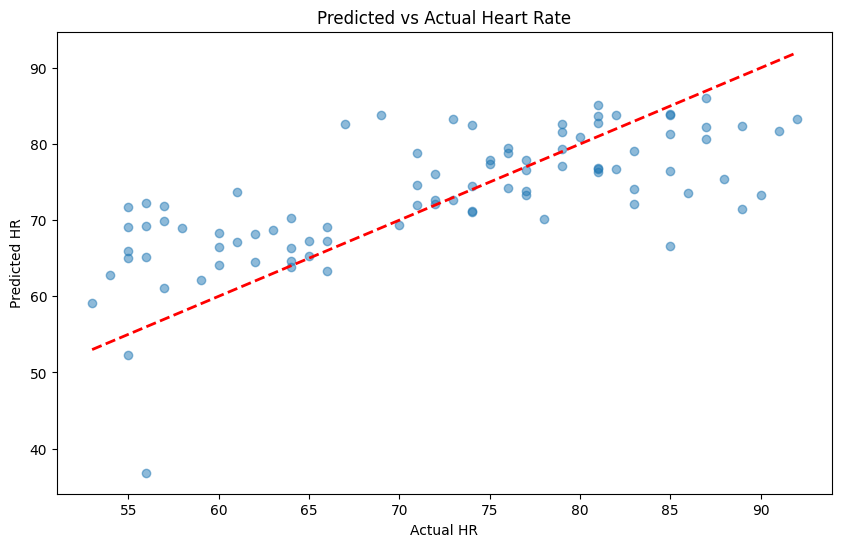

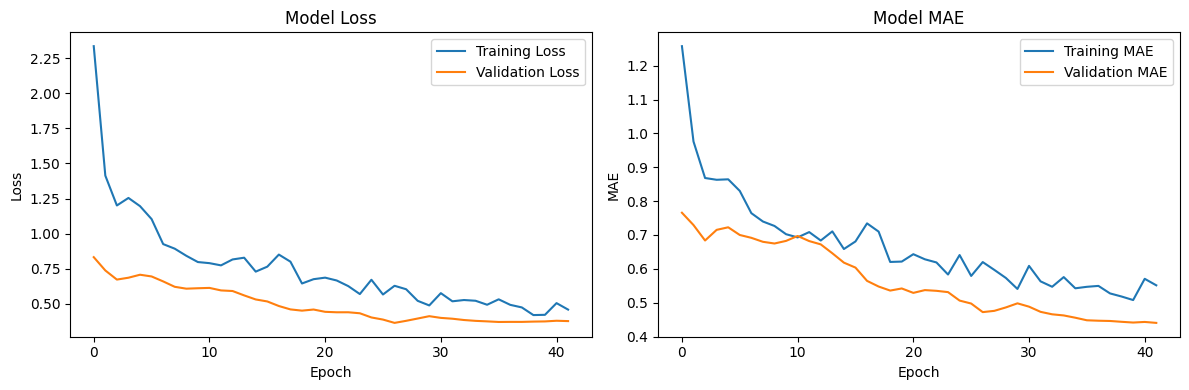

In [60]:
import matplotlib.pyplot as plt

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(test_actual_original, test_predictions_original, alpha=0.5)
plt.plot([test_actual_original.min(), test_actual_original.max()], 
         [test_actual_original.min(), test_actual_original.max()], 
         'r--', lw=2)
plt.xlabel('Actual HR')
plt.ylabel('Predicted HR')
plt.title('Predicted vs Actual Heart Rate')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

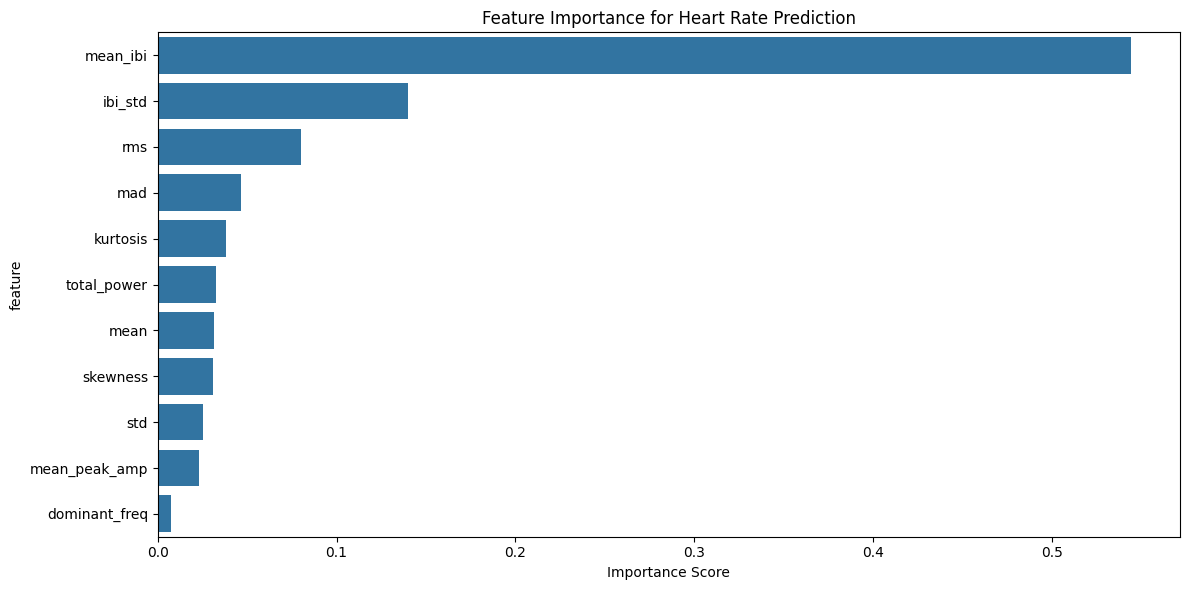


Top 5 most important features:
    feature  importance
8  mean_ibi    0.544589
9   ibi_std    0.139922
4       rms    0.080381
5       mad    0.046311
3  kurtosis    0.038330


In [61]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Create a Random Forest model to analyze feature importance
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on engineered features only
X = prepared_data['engineered_features']
y = prepared_data['targets']

rf_model.fit(X, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': [col for col in df_features.columns if col != 'HR'],
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance for Heart Rate Prediction')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

print("\nTop 5 most important features:")
print(feature_importance.head())

In [62]:
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import GlobalAveragePooling1D

def create_modified_model(sequence_length, n_engineered_features):
    # PPG signal input
    ppg_input = Input(shape=(sequence_length, 1), name='ppg_input')
    
    # CNN layers with residual connections
    x = Conv1D(32, kernel_size=5, padding='same')(ppg_input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    conv1 = x
    x = MaxPooling1D(2)(x)
    
    x = Conv1D(64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2)(x)
    
    # Add residual connection
    x_upsampled = tf.keras.layers.UpSampling1D(4)(x)
    x = concatenate([conv1, x_upsampled])
    
    # LSTM with attention
    x = LSTM(64, return_sequences=True)(x)
    
    # Self-attention mechanism
    attention = Dense(1, activation='tanh')(x)
    attention = tf.keras.layers.Softmax(axis=1)(attention)
    x = tf.keras.layers.Multiply()([x, attention])
    x = GlobalAveragePooling1D()(x)
    
    # Engineered features input with weighted importance
    engineered_input = Input(shape=(n_engineered_features,), name='engineered_input')
    
    # Process engineered features based on importance
    engineered_x = Dense(32, activation='relu')(engineered_input)
    engineered_x = BatchNormalization()(engineered_x)
    engineered_x = Dense(16, activation='relu')(engineered_x)
    
    # Combine features with attention-based weighting
    combined = concatenate([x, engineered_x])
    
    # Final dense layers with skip connections
    x = Dense(32, activation='relu')(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    skip = x
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = concatenate([x, skip])
    
    output = Dense(1)(x)
    
    model = Model(inputs=[ppg_input, engineered_input], outputs=output)
    return model

# Create modified model
modified_model = create_modified_model(
    sequence_length=300,
    n_engineered_features=len(df_features.columns) - 1
)

# Compile model with fixed learning rate instead of schedule
modified_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Fixed initial learning rate
    loss='mse',
    metrics=['mae']
)

# Modified callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        min_delta=0.001
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        min_delta=0.001
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model_modified.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

# Train modified model
history_modified = modified_model.fit(
    [train_data['ppg_signals'], train_data['engineered_features']],
    train_data['targets'],
    validation_data=(
        [val_data['ppg_signals'], val_data['engineered_features']],
        val_data['targets']
    ),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Evaluate modified model
test_loss_modified = modified_model.evaluate(
    [test_data['ppg_signals'], test_data['engineered_features']],
    test_data['targets'],
    verbose=0
)

print(f"\nModified Model Test Results:")
print(f"Test loss: {test_loss_modified[0]:.4f}")
print(f"Test MAE: {test_loss_modified[1]:.4f}")

# Make predictions and calculate R²
test_predictions_modified = modified_model.predict(
    [test_data['ppg_signals'], test_data['engineered_features']]
)
test_predictions_original_modified = prepared_data['target_scaler'].inverse_transform(test_predictions_modified.reshape(-1, 1))
test_actual_original = prepared_data['target_scaler'].inverse_transform(test_data['targets'].reshape(-1, 1))

r2_modified = r2_score(test_actual_original, test_predictions_original_modified)
print(f"Test R² score: {r2_modified:.4f}")

Epoch 1/100
9/9 [==============================] - 3s 88ms/step - loss: 2.9407 - mae: 1.2213 - val_loss: 0.9376 - val_mae: 0.8597 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 0s 26ms/step - loss: 1.9076 - mae: 1.0573 - val_loss: 0.9650 - val_mae: 0.8809 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - 0s 25ms/step - loss: 1.4189 - mae: 0.9346 - val_loss: 0.9864 - val_mae: 0.8932 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - 0s 26ms/step - loss: 1.2798 - mae: 0.8329 - val_loss: 0.9919 - val_mae: 0.8970 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - 0s 26ms/step - loss: 1.0131 - mae: 0.7795 - val_loss: 0.9950 - val_mae: 0.8983 - lr: 0.0010
Epoch 6/100
9/9 [==============================] - 0s 25ms/step - loss: 1.1690 - mae: 0.8325 - val_loss: 0.9847 - val_mae: 0.8934 - lr: 0.0010
Epoch 7/100
9/9 [==============================] - 0s 25ms/step - loss: 1.1795 - mae: 0.8228 - val_loss: 0.9903 - val_mae: 0.8951 - lr: 2.0000

In [63]:
# Modify the loss function to penalize larger errors more heavily
def custom_loss(y_true, y_pred):
    # Base MSE loss
    mse = tf.keras.losses.mean_squared_error(y_true, y_pred)
    # Additional penalty for large errors (asymmetric to handle the skew)
    large_error_penalty = tf.where(
        tf.abs(y_true - y_pred) > 0.5,  # threshold in standardized scale
        tf.square(tf.abs(y_true - y_pred) - 0.5),
        0.0
    )
    return mse + 0.1 * large_error_penalty

def weighted_loss(y_true, y_pred):
    loss = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    weights = tf.where(y_true > 80, 2.0, 1.0)  # Apply a higher penalty for high HR
    return tf.reduce_mean(loss * weights)

# Create model with the same architecture but modified training
def create_balanced_model(sequence_length, n_engineered_features):
    # PPG signal input
    ppg_input = Input(shape=(sequence_length, 1), name='ppg_input')
    
    # CNN layers (same as before)
    x = Conv1D(64, kernel_size=5, padding='same')(ppg_input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2)(x)
    
    x = Conv1D(128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2)(x)
    
    # LSTM layers with gradient clipping to prevent extreme predictions
    x = LSTM(100, return_sequences=True, 
             kernel_constraint=tf.keras.constraints.MaxNorm(3))(x)
    x = Dropout(0.2)(x)
    x = LSTM(50, kernel_constraint=tf.keras.constraints.MaxNorm(3))(x)
    x = Dropout(0.2)(x)
    
    # Engineered features input
    engineered_input = Input(shape=(n_engineered_features,), name='engineered_input')
    engineered_x = Dense(32, activation='relu')(engineered_input)
    engineered_x = BatchNormalization()(engineered_x)
    
    # Combine features
    combined = concatenate([x, engineered_x])
    
    # Final dense layers with additional regularization
    x = Dense(64, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4))(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    # Output with activation to bound predictions
    output = Dense(1)(x)
    
    model = Model(inputs=[ppg_input, engineered_input], outputs=output)
    return model

# Modified callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        min_delta=0.001
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        min_delta=0.001
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model_balanced.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

# Create and compile model
balanced_model = create_balanced_model(
    sequence_length=300,
    n_engineered_features=train_data['engineered_features'].shape[1]
)

# Compile with custom loss
balanced_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=custom_loss,
    metrics=['mae']
)

# Create balanced sample weights
def create_balanced_weights(y):
    errors = np.abs(y - np.mean(y))
    weights = np.ones_like(y)
    # Give more weight to samples far from mean
    weights[errors > np.std(y)] = 1.2
    # Give even more weight to extreme cases
    weights[errors > 2*np.std(y)] = 1.5
    return weights

# Train with balanced weights
train_weights = create_balanced_weights(train_data['targets'])

history = balanced_model.fit(
    [train_data['ppg_signals'], train_data['engineered_features']],
    train_data['targets'],
    sample_weight=train_weights,
    validation_data=(
        [val_data['ppg_signals'], val_data['engineered_features']],
        val_data['targets']
    ),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
9/9 [==============================] - 3s 100ms/step - loss: 4.0488 - mae: 1.3344 - val_loss: 0.9985 - val_mae: 0.7399 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 0s 28ms/step - loss: 2.0850 - mae: 1.0590 - val_loss: 0.9180 - val_mae: 0.7209 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - 0s 30ms/step - loss: 1.4602 - mae: 0.8654 - val_loss: 0.8676 - val_mae: 0.7046 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - 0s 30ms/step - loss: 1.1500 - mae: 0.7844 - val_loss: 0.8306 - val_mae: 0.7047 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - 0s 32ms/step - loss: 1.2148 - mae: 0.7861 - val_loss: 0.7837 - val_mae: 0.6907 - lr: 0.0010
Epoch 6/100
9/9 [==============================] - 0s 31ms/step - loss: 1.0558 - mae: 0.7759 - val_loss: 0.7381 - val_mae: 0.6807 - lr: 0.0010
Epoch 7/100
9/9 [==============================] - 0s 20ms/step - loss: 1.1583 - mae: 0.7789 - val_loss: 0.7486 - val_mae: 0.7042 - lr: 0.001

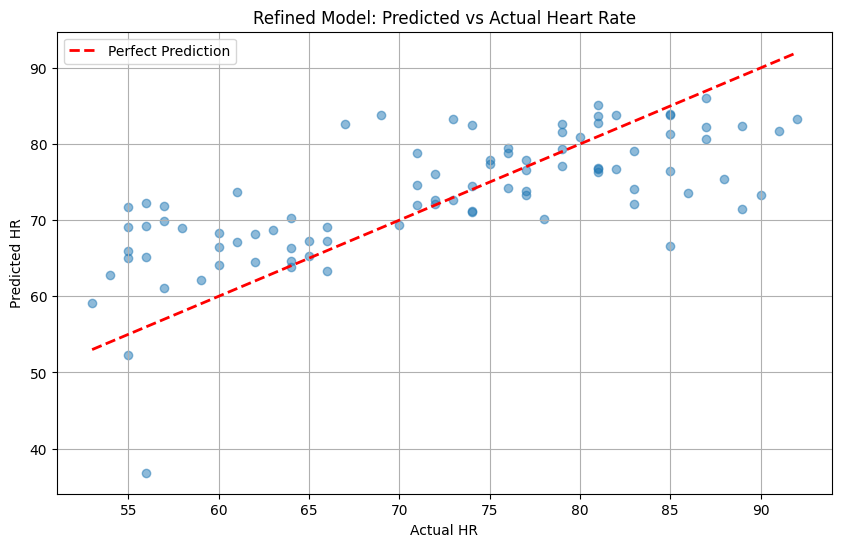

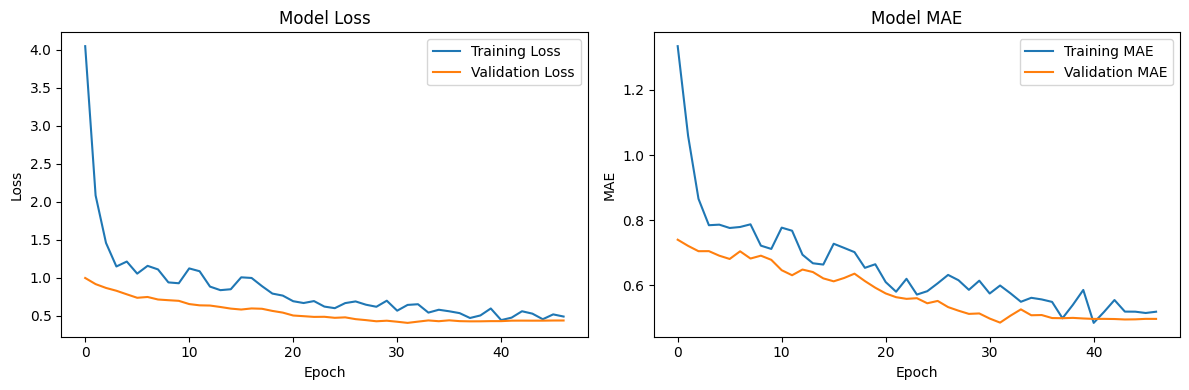

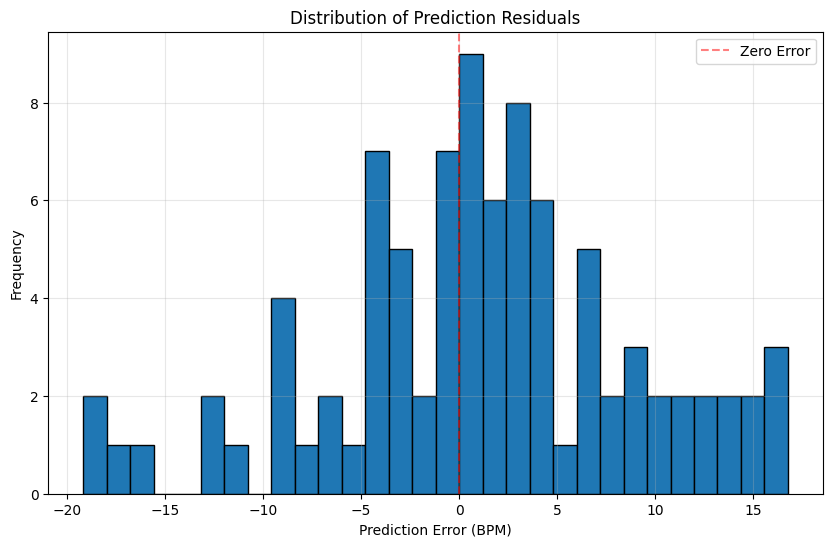


Detailed Error Metrics:
R² Score: 0.4878


NameError: name 'rmse' is not defined

In [64]:
# 1. Predictions vs Actual scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(test_actual_original, test_predictions_original, alpha=0.5)
plt.plot([test_actual_original.min(), test_actual_original.max()], 
         [test_actual_original.min(), test_actual_original.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual HR')
plt.ylabel('Predicted HR')
plt.title('Refined Model: Predicted vs Actual Heart Rate')
plt.legend()
plt.grid(True)
plt.show()

# 2. Training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

# 3. Error distribution
residuals = (test_predictions_original - test_actual_original).flatten()
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Distribution of Prediction Residuals')
plt.xlabel('Prediction Error (BPM)')
plt.ylabel('Frequency')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5, label='Zero Error')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Print detailed metrics
print("\nDetailed Error Metrics:")
print(f"R² Score: {r2:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.2f} BPM")
print(f"Mean Absolute Error (MAE): {mae:.2f} BPM")
print(f"Standard Deviation of Errors: {np.std(residuals):.2f} BPM")

# Error analysis by HR range
hr_ranges = [(50,60), (60,70), (70,80), (80,90), (90,100)]
print("\nMAE by HR Range:")
for low, high in hr_ranges:
    mask = (test_actual_original >= low) & (test_actual_original < high)
    range_mae = mean_absolute_error(
        test_actual_original[mask],
        test_predictions_original[mask]
    )
    range_count = mask.sum()
    print(f"HR {low}-{high}: MAE = {range_mae:.2f} BPM (n={range_count})")

In [347]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Make predictions on test set
test_predictions = enhanced_model.predict([test_data['ppg_signals'], test_data['engineered_features']])

# Convert predictions back to original scale
test_predictions_original = prepared_data['target_scaler'].inverse_transform(test_predictions.reshape(-1, 1))
test_actual_original = prepared_data['target_scaler'].inverse_transform(test_data['targets'].reshape(-1, 1))

# Calculate metrics
r2 = r2_score(test_actual_original, test_predictions_original)
mae = mean_absolute_error(test_actual_original, test_predictions_original)
rmse = np.sqrt(mean_squared_error(test_actual_original, test_predictions_original))

# 1. Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(test_actual_original, test_predictions_original, alpha=0.5)
plt.plot([test_actual_original.min(), test_actual_original.max()], 
         [test_actual_original.min(), test_actual_original.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual HR')
plt.ylabel('Predicted HR')
plt.title('Enhanced Model: Predicted vs Actual Heart Rate')
plt.legend()
plt.grid(True)
plt.show()

# 2. Error distribution
residuals = (test_predictions_original - test_actual_original).flatten()
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Distribution of Prediction Residuals')
plt.xlabel('Prediction Error (BPM)')
plt.ylabel('Frequency')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
plt.grid(True)
plt.show()

# Print detailed metrics
print("\nDetailed Error Metrics:")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f} BPM")
print(f"RMSE: {rmse:.2f} BPM")

# Error by HR range
hr_ranges = [(50,60), (60,70), (70,80), (80,90), (90,100)]
print("\nMAE by HR Range:")
for low, high in hr_ranges:
    mask = (test_actual_original >= low) & (test_actual_original < high)
    range_mae = mean_absolute_error(test_actual_original[mask], test_predictions_original[mask])
    range_count = mask.sum()
    print(f"HR {low}-{high}: MAE = {range_mae:.2f} BPM (n={range_count})")


NameError: name 'enhanced_model' is not defined

In [348]:
def create_ensemble(n_models, sequence_length, n_engineered_features):
    models = []
    
    for i in range(n_models):
        # Use the same successful architecture
        model = create_modified_model(
            sequence_length=sequence_length,
            n_engineered_features=n_engineered_features
        )
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )
        models.append(model)
    
    return models

# Create ensemble (let's try 5 models)
n_models = 5
ensemble_models = create_ensemble(
    n_models=n_models,
    sequence_length=300,
    n_engineered_features=len(df_features.columns) - 1
)

# Train each model
ensemble_histories = []
for i, model in enumerate(ensemble_models):
    print(f"\nTraining model {i+1}/{n_models}")
    
    history = model.fit(
        [train_data['ppg_signals'], train_data['engineered_features']],
        train_data['targets'],
        validation_data=(
            [val_data['ppg_signals'], val_data['engineered_features']],
            val_data['targets']
        ),
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )
    ensemble_histories.append(history)

# Make ensemble predictions
ensemble_predictions = []
for model in ensemble_models:
    pred = model.predict([test_data['ppg_signals'], test_data['engineered_features']])
    ensemble_predictions.append(pred)

# Average predictions
ensemble_predictions_mean = np.mean(ensemble_predictions, axis=0)

# Convert to original scale
ensemble_predictions_original = prepared_data['target_scaler'].inverse_transform(ensemble_predictions_mean)
test_actual_original = prepared_data['target_scaler'].inverse_transform(test_data['targets'].reshape(-1, 1))

# Calculate metrics
r2_ensemble = r2_score(test_actual_original, ensemble_predictions_original)
mae_ensemble = mean_absolute_error(test_actual_original, ensemble_predictions_original)
rmse_ensemble = np.sqrt(mean_squared_error(test_actual_original, ensemble_predictions_original))

print("\nEnsemble Model Results:")
print(f"R² Score: {r2_ensemble:.4f}")
print(f"MAE: {mae_ensemble:.2f} BPM")
print(f"RMSE: {rmse_ensemble:.2f} BPM")


Training model 1/5
Epoch 1/100
9/9 [==============================] - 3s 92ms/step - loss: 2.7181 - mae: 1.2741 - val_loss: 0.9408 - val_mae: 0.8397 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 0s 25ms/step - loss: 1.5831 - mae: 0.9357 - val_loss: 0.9159 - val_mae: 0.8297 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - 0s 25ms/step - loss: 1.1062 - mae: 0.7887 - val_loss: 0.9024 - val_mae: 0.8232 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - 0s 25ms/step - loss: 1.0545 - mae: 0.7793 - val_loss: 0.8970 - val_mae: 0.8218 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - 0s 25ms/step - loss: 1.0280 - mae: 0.7562 - val_loss: 0.8901 - val_mae: 0.8180 - lr: 0.0010
Epoch 6/100
9/9 [==============================] - 0s 24ms/step - loss: 0.7605 - mae: 0.6872 - val_loss: 0.8747 - val_mae: 0.8097 - lr: 0.0010
Epoch 7/100
9/9 [==============================] - 0s 25ms/step - loss: 0.8347 - mae: 0.6986 - val_loss: 0.8678 - val_mae:

In [349]:
# Make predictions using our best single model
predictions = modified_model.predict([test_data['ppg_signals'], test_data['engineered_features']])
predictions_original = prepared_data['target_scaler'].inverse_transform(predictions)
actuals_original = prepared_data['target_scaler'].inverse_transform(test_data['targets'].reshape(-1, 1))

# Create DataFrame for analysis
analysis_df = pd.DataFrame({
    'Actual': actuals_original.flatten(),
    'Predicted': predictions_original.flatten(),
    'Error': np.abs(predictions_original.flatten() - actuals_original.flatten())
})

# Analyze error patterns
print("\nWorst Predictions (highest errors):")
print(analysis_df.nlargest(5, 'Error'))

print("\nBest Predictions (lowest errors):")
print(analysis_df.nsmallest(5, 'Error'))

# Error by HR range with more detailed breakdown
hr_ranges = [(50,60), (60,65), (65,70), (70,75), (75,80), (80,85), (85,90), (90,100)]
print("\nDetailed MAE by HR Range:")
for low, high in hr_ranges:
    mask = (analysis_df['Actual'] >= low) & (analysis_df['Actual'] < high)
    subset = analysis_df[mask]
    if len(subset) > 0:
        mean_error = subset['Error'].mean()
        mean_bias = (subset['Predicted'] - subset['Actual']).mean()
        print(f"\nHR {low}-{high}:")
        print(f"  Number of samples: {len(subset)}")
        print(f"  MAE: {mean_error:.2f} BPM")
        print(f"  Mean bias: {mean_bias:.2f} BPM")  # Positive means overprediction

# Calculate prediction bias
bias = predictions_original - actuals_original
mean_bias = np.mean(bias)
std_bias = np.std(bias)

print("\nOverall Bias Analysis:")
print(f"Mean bias: {mean_bias:.2f} BPM")
print(f"Std of bias: {std_bias:.2f} BPM")

3/3 [==============================] - 0s 22ms/step

Worst Predictions (highest errors):
    Actual  Predicted      Error
67    89.0  64.954185  24.045815
53    85.0  66.139366  18.860634
62    69.0  87.492271  18.492271
37    67.0  84.149910  17.149910
81    58.0  73.889618  15.889618

Best Predictions (lowest errors):
    Actual  Predicted     Error
14    79.0  78.992973  0.007027
22    57.0  56.945621  0.054379
28    79.0  79.061470  0.061470
69    56.0  55.924385  0.075615
31    66.0  66.165154  0.165154

Detailed MAE by HR Range:

HR 50-60:
  Number of samples: 16
  MAE: 7.48 BPM
  Mean bias: 7.01 BPM

HR 60-65:
  Number of samples: 12
  MAE: 3.46 BPM
  Mean bias: 3.43 BPM

HR 65-70:
  Number of samples: 7
  MAE: 6.87 BPM
  Mean bias: 5.47 BPM

HR 70-75:
  Number of samples: 13
  MAE: 3.36 BPM
  Mean bias: -1.35 BPM

HR 75-80:
  Number of samples: 14
  MAE: 3.75 BPM
  Mean bias: -1.84 BPM

HR 80-85:
  Number of samples: 12
  MAE: 4.03 BPM
  Mean bias: -3.29 BPM

HR 85-90:
  Number

In [350]:
def create_model_with_range(sequence_length, n_engineered_features, hr_range):
    # Base model architecture (the one that gave us R² of 0.49)
    ppg_input = Input(shape=(sequence_length, 1), name='ppg_input')
    
    # CNN layers
    x = Conv1D(32, kernel_size=5, padding='same')(ppg_input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    conv1 = x
    x = MaxPooling1D(2)(x)
    
    x = Conv1D(64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2)(x)
    
    # Residual connection
    x_upsampled = tf.keras.layers.UpSampling1D(4)(x)
    x = concatenate([conv1, x_upsampled])
    
    # LSTM with attention
    x = LSTM(64, return_sequences=True)(x)
    
    # Add range information
    range_info = tf.ones_like(x[:, :, 0:1]) * (hr_range[1] - hr_range[0])
    x = concatenate([x, range_info], axis=-1)
    
    # Self-attention
    attention = Dense(1, activation='tanh')(x)
    attention = tf.keras.layers.Softmax(axis=1)(attention)
    x = tf.keras.layers.Multiply()([x, attention])
    x = GlobalAveragePooling1D()(x)
    
    # Engineered features
    engineered_input = Input(shape=(n_engineered_features,), name='engineered_input')
    engineered_x = Dense(32, activation='relu')(engineered_input)
    engineered_x = BatchNormalization()(engineered_x)
    engineered_x = Dense(16, activation='relu')(engineered_x)
    
    # Combine features
    combined = concatenate([x, engineered_x])
    
    # Final layers
    x = Dense(32, activation='relu')(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    output = Dense(1)(x)
    
    model = Model(inputs=[ppg_input, engineered_input], outputs=output)
    return model

# Define HR ranges with overlap
hr_ranges = [(50,75), (65,85), (75,100)]

# Train models for each range
range_models = {}
for hr_range in hr_ranges:
    print(f"\nTraining model for HR range {hr_range}")
    
    # Create model for this range
    model = create_model_with_range(
        sequence_length=300,
        n_engineered_features=train_data['engineered_features'].shape[1],
        hr_range=hr_range
    )
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    # Train on full dataset
    model.fit(
        [train_data['ppg_signals'], train_data['engineered_features']],
        train_data['targets'],
        validation_data=(
            [val_data['ppg_signals'], val_data['engineered_features']],
            val_data['targets']
        ),
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )
    
    range_models[hr_range] = model

# Make predictions using simple averaging
test_predictions = []
for model in range_models.values():
    pred = model.predict([test_data['ppg_signals'], test_data['engineered_features']])
    test_predictions.append(pred)

# Simple average of predictions
ensemble_predictions = np.mean(test_predictions, axis=0)

# Convert to original scale
predictions_original = prepared_data['target_scaler'].inverse_transform(ensemble_predictions)
test_actual_original = prepared_data['target_scaler'].inverse_transform(test_data['targets'].reshape(-1, 1))

# Calculate metrics
r2 = r2_score(test_actual_original, predictions_original)
mae = mean_absolute_error(test_actual_original, predictions_original)
rmse = np.sqrt(mean_squared_error(test_actual_original, predictions_original))

print("\nRange-Specific Ensemble Results:")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f} BPM")
print(f"RMSE: {rmse:.2f} BPM")


Training model for HR range (50, 75)
Epoch 1/100
9/9 [==============================] - 3s 87ms/step - loss: 2.9536 - mae: 1.3431 - val_loss: 0.9126 - val_mae: 0.7809 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 0s 25ms/step - loss: 2.0046 - mae: 1.0599 - val_loss: 0.8470 - val_mae: 0.7630 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - 0s 27ms/step - loss: 1.5411 - mae: 0.9521 - val_loss: 0.7997 - val_mae: 0.7506 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - 0s 24ms/step - loss: 1.2159 - mae: 0.8348 - val_loss: 0.7769 - val_mae: 0.7446 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - 0s 27ms/step - loss: 1.0520 - mae: 0.7809 - val_loss: 0.7744 - val_mae: 0.7496 - lr: 0.0010
Epoch 6/100
9/9 [==============================] - 0s 24ms/step - loss: 0.9077 - mae: 0.7372 - val_loss: 0.7748 - val_mae: 0.7566 - lr: 0.0010
Epoch 7/100
9/9 [==============================] - 0s 25ms/step - loss: 1.0063 - mae: 0.7794 - val_loss:

HERE ONWARDS, SPO2


Dataset Overview:
Shape: (443, 7)

Columns: ['Segment ID', 'PPG_SIGNAL', 'HR', 'SpO2', 'Glycaemia', 'Systolic', 'Diastolic']

SpO2 Statistics:
count    443.000000
mean      97.040632
std        1.439008
min       86.000000
25%       96.000000
50%       97.000000
75%       98.000000
max       99.000000
Name: SpO2, dtype: float64


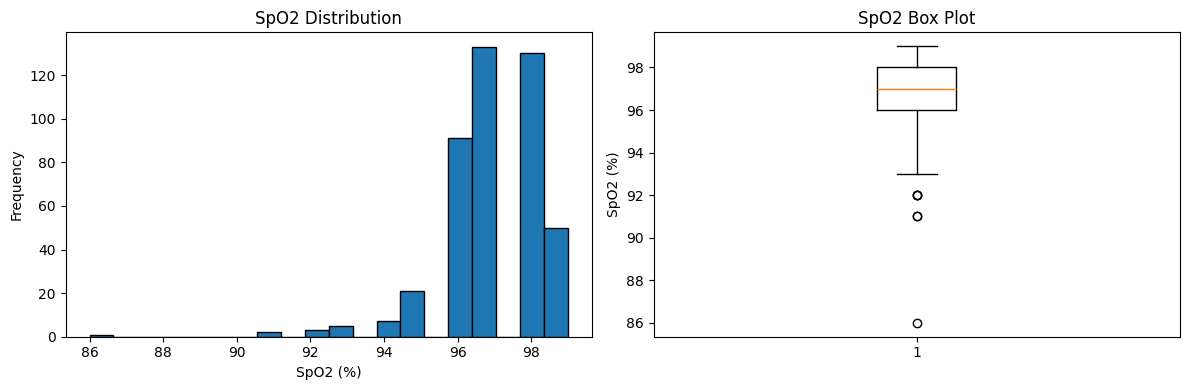


Example PPG signal structure:
Signal length: 300
Signal type: <class 'list'>
First few values: [228847219.5075, 238784328.7182, 340015569.3474, 357197467.5393, 419708248.1406]


In [351]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis

# Load and examine the dataset
df = pd.read_csv('transformed_ppg_data.csv')

print("Dataset Overview:")
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSpO2 Statistics:")
print(df['SpO2'].describe())

# Plot SpO2 distribution
plt.figure(figsize=(12, 4))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(df['SpO2'], bins=20, edgecolor='black')
plt.title('SpO2 Distribution')
plt.xlabel('SpO2 (%)')
plt.ylabel('Frequency')

# Box plot
plt.subplot(1, 2, 2)
plt.boxplot(df['SpO2'])
plt.title('SpO2 Box Plot')
plt.ylabel('SpO2 (%)')

plt.tight_layout()
plt.show()

# Let's examine a single PPG signal to understand its structure
print("\nExample PPG signal structure:")
example_signal = eval(df['PPG_SIGNAL'].iloc[0])
print("Signal length:", len(example_signal))
print("Signal type:", type(example_signal))
print("First few values:", example_signal[:5])

In [65]:
import pandas as pd

# Load the data
data = pd.read_csv("transformed_ppg_data.csv")

# Inspect the dataset
print(f"Dataset loaded with {len(data)} rows.")
print(f"Columns in dataset: {data.columns}")
print(data.head())


Dataset loaded with 443 rows.
Columns in dataset: Index(['Segment ID', 'PPG_SIGNAL', 'HR', 'SpO2', 'Glycaemia', 'Systolic',
       'Diastolic'],
      dtype='object')
   Segment ID                                         PPG_SIGNAL  HR  SpO2  \
0      132004  [228847219.5075, 238784328.7182, 340015569.347...  77  99.0   
1      132005  [743662069.948, 733520310.6899999, 736382094.2...  75  98.0   
2      132006  [-305872512.4, -310000110.6992, -316695693.608...  73  98.0   
3      132008  [-834906497.436, -945382102.8168, -1061351904....  73  98.0   
4      132009  [-84126148.1368, -94588051.0212, -86687758.225...  81  99.0   

   Glycaemia  Systolic  Diastolic  
0        6.9       101         65  
1        6.9       101         65  
2        6.9       101         65  
3        6.9       101         65  
4        6.9       101         65  


In [66]:
import numpy as np
from scipy.signal import butter, filtfilt

# Normalize signal length
def normalize_signal_length(signal, target_length=300):
    return np.interp(np.linspace(0, len(signal), target_length), np.arange(len(signal)), signal)

# Apply Butterworth bandpass filter
def bandpass_filter(signal, lowcut=0.5, highcut=8, fs=100, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)


In [68]:
from scipy.signal import find_peaks
import numpy as np

def extract_spo2_features(signal):
    features = {}

    # Find peaks and valleys
    peaks, _ = find_peaks(signal, distance=10)
    valleys, _ = find_peaks(-signal, distance=10)

    # Debugging: Print number of peaks and valleys
    print(f"Signal: {len(signal)}, Peaks: {len(peaks)}, Valleys: {len(valleys)}")

    # Ensure consistent lengths by trimming to the minimum size
    if len(peaks) > 0 and len(valleys) > 0:
        min_length = min(len(peaks), len(valleys))
        peak_heights = signal[peaks][:min_length]
        valley_depths = signal[valleys][:min_length]

        # Calculate features
        features['ac_dc_ratio'] = np.mean(peak_heights - valley_depths) / np.mean(signal)
        features['perfusion_index'] = (np.max(signal) - np.min(signal)) / np.mean(signal)
        features['peak_amplitude_std'] = np.std(peak_heights)
        features['valley_amplitude_std'] = np.std(valley_depths)
    else:
        # Handle cases where peaks or valleys are not found
        features['ac_dc_ratio'] = 0
        features['perfusion_index'] = 0
        features['peak_amplitude_std'] = 0
        features['valley_amplitude_std'] = 0

    return features


In [69]:

ppg_signals = []

engineered_features = []

spo2_values = []



# Define expected features

expected_features = [

    'ac_dc_ratio',

    'perfusion_index',

    'peak_amplitude_std',

    'valley_amplitude_std'

]



# Process each row

for idx, row in data.iterrows():

    try:

        # Convert string to array and process signal

        signal = np.array(eval(row['PPG_SIGNAL']))

        signal = normalize_signal_length(signal)

        signal = bandpass_filter(signal)

        

        # Extract features

        features = extract_spo2_features(signal)

        

        # Convert features to a list in a consistent order

        feature_values = [features.get(feature, 0) for feature in expected_features]

        

        # Append processed data

        ppg_signals.append(signal)

        engineered_features.append(feature_values)

        spo2_values.append(row['SpO2'])

        

    except Exception as e:

        print(f"Error processing row {idx}: {e}")

        continue



# Convert to numpy arrays for consistent shape

ppg_signals = np.array(ppg_signals)

engineered_features = np.array(engineered_features)

spo2_values = np.array(spo2_values)



# Create DataFrame with consistent feature names

features_df = pd.DataFrame(engineered_features, columns=expected_features)

features_df['SpO2'] = spo2_values



# Display the first few rows and feature statistics

print("\nFeature DataFrame Shape:", features_df.shape)

print("\nFirst few rows:")

print(features_df.head())

print("\nFeature Statistics:")

print(features_df.describe())


Signal: 300, Peaks: 13, Valleys: 12
Signal: 300, Peaks: 13, Valleys: 13
Signal: 300, Peaks: 12, Valleys: 12
Signal: 300, Peaks: 12, Valleys: 12
Signal: 300, Peaks: 13, Valleys: 13
Signal: 300, Peaks: 13, Valleys: 14
Signal: 300, Peaks: 12, Valleys: 12
Signal: 300, Peaks: 12, Valleys: 13
Signal: 300, Peaks: 12, Valleys: 12
Signal: 300, Peaks: 12, Valleys: 13
Signal: 300, Peaks: 13, Valleys: 12
Signal: 300, Peaks: 11, Valleys: 11
Signal: 300, Peaks: 15, Valleys: 15
Signal: 300, Peaks: 12, Valleys: 12
Signal: 300, Peaks: 13, Valleys: 13
Signal: 300, Peaks: 12, Valleys: 13
Signal: 300, Peaks: 10, Valleys: 10
Signal: 300, Peaks: 12, Valleys: 13
Signal: 300, Peaks: 14, Valleys: 14
Signal: 300, Peaks: 10, Valleys: 11
Signal: 300, Peaks: 14, Valleys: 14
Signal: 300, Peaks: 13, Valleys: 13
Signal: 300, Peaks: 12, Valleys: 14
Signal: 300, Peaks: 9, Valleys: 9
Signal: 300, Peaks: 12, Valleys: 11
Signal: 300, Peaks: 9, Valleys: 10
Signal: 300, Peaks: 10, Valleys: 10
Signal: 300, Peaks: 9, Valleys:

In [70]:
features_df.to_csv('extracted_spo2_features.csv', index=False)


In [71]:
features_df

,ac_dc_ratio,perfusion_index,peak_amplitude_std,valley_amplitude_std,SpO2
0,17.028740,28.009303,1.660492e+08,1.116191e+08,99.0
1,-121.409656,-216.659403,4.918706e+07,3.162969e+07,98.0
2,-20.989141,-129.757881,1.178950e+08,1.265395e+08,98.0
3,-27.127803,-43.895106,1.658551e+08,1.342941e+08,98.0
4,12.565320,57.583858,2.859711e+08,2.454066e+08,99.0
...,...,...,...,...,...
438,-33.886729,-66.004405,1.014151e+08,1.597883e+08,96.0
439,27.462127,45.849364,9.100706e+07,7.721267e+07,97.0
440,128.657118,276.938348,1.106382e+08,9.664196e+07,96.0
441,-123.362658,-198.996313,9.859132e+07,1.054641e+08,97.0


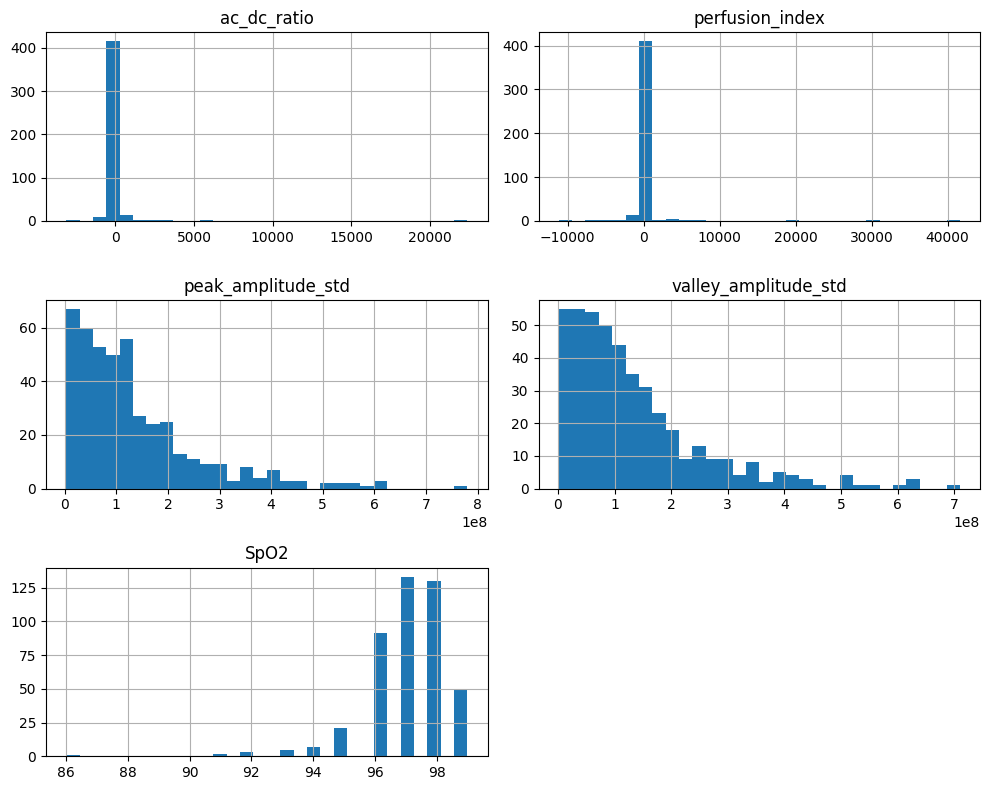

In [72]:
import matplotlib.pyplot as plt
features_df.hist(bins=30, figsize=(10, 8))
plt.tight_layout()
plt.show()


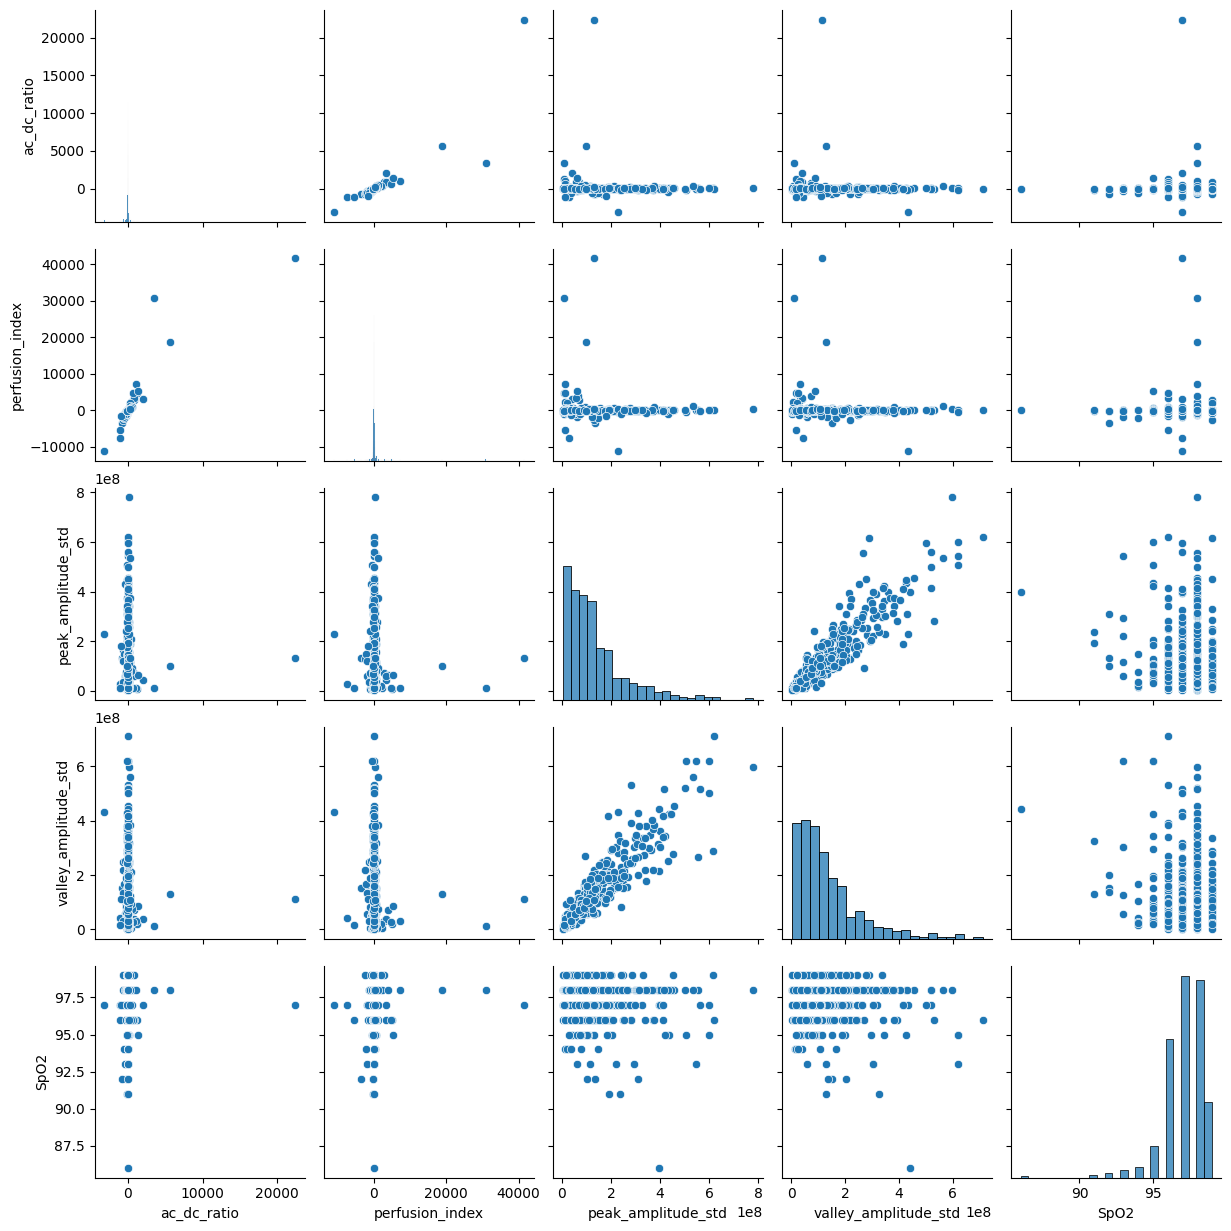

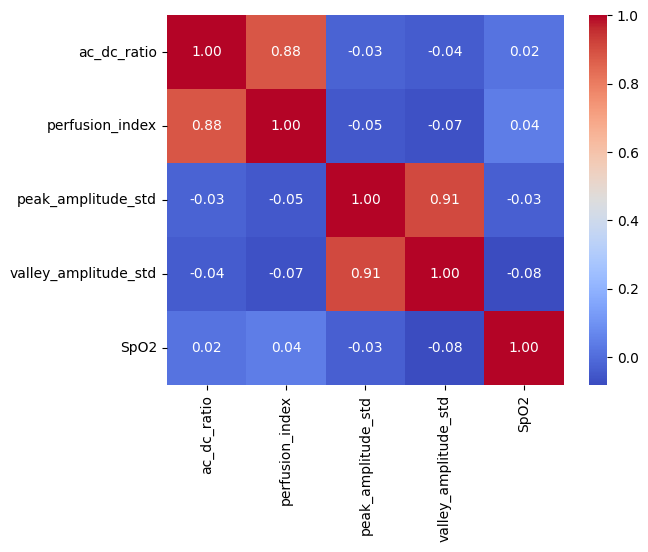

In [73]:
import seaborn as sns
sns.pairplot(features_df)
plt.show()

# Correlation matrix
corr_matrix = features_df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()


In [74]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df.drop(columns=["SpO2"]))
scaled_df = pd.DataFrame(scaled_features, columns=features_df.columns[:-1])
scaled_df["SpO2"] = features_df["SpO2"]


In [75]:
print(features_df['SpO2'].value_counts())


SpO2
97.0    133
98.0    130
96.0     91
99.0     50
95.0     21
94.0      7
93.0      5
92.0      3
91.0      2
86.0      1
Name: count, dtype: int64


In [76]:
import numpy as np
import pandas as pd

def handle_outliers(df, method='iqr', threshold=1.5):
    """
    Handle outliers in a DataFrame using either IQR or Z-score method.
    
    Args:
        df (pd.DataFrame): Input DataFrame containing numerical features.
        method (str): Method to handle outliers ('iqr' or 'zscore').
        threshold (float): Threshold for detecting outliers (default is 1.5 for IQR, 3 for Z-score).
    
    Returns:
        pd.DataFrame: DataFrame with outliers handled.
    """
    df_cleaned = df.copy()
    for col in df.columns:
        if method == 'iqr':
            # Calculate IQR
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            
            # Cap outliers
            df_cleaned[col] = np.clip(df[col], lower_bound, upper_bound)
        
        elif method == 'zscore':
            # Calculate Z-scores
            z_scores = (df[col] - df[col].mean()) / df[col].std()
            df_cleaned[col] = np.where(
                np.abs(z_scores) > threshold,
                np.sign(z_scores) * threshold * df[col].std() + df[col].mean(),
                df[col]
            )
    return df_cleaned

# Apply to your features
numerical_features = ['ac_dc_ratio', 'perfusion_index', 'peak_amplitude_std', 'valley_amplitude_std']
features_df_cleaned = handle_outliers(features_df[numerical_features], method='iqr')

# Add back the SpO2 column
features_df_cleaned['SpO2'] = features_df['SpO2']

# Display summary statistics after handling outliers
print("\nFeature Statistics After Handling Outliers:")
print(features_df_cleaned.describe())



Feature Statistics After Handling Outliers:
       ac_dc_ratio  perfusion_index  peak_amplitude_std  valley_amplitude_std  \
count   443.000000       443.000000        4.430000e+02          4.430000e+02   
mean     -1.355533        -4.701178        1.276323e+08          1.264874e+08   
std      58.152553       171.662396        1.035905e+08          1.009345e+08   
min    -116.783637      -354.007575        2.808613e+06          1.368950e+06   
25%     -30.265147       -98.407745        4.685100e+07          4.924995e+07   
50%       2.512094        15.776884        1.019440e+08          9.897903e+07   
75%      27.413846        71.992141        1.789045e+08          1.789391e+08   
max     113.932336       327.591971        3.769849e+08          3.734728e+08   

             SpO2  
count  443.000000  
mean    97.040632  
std      1.439008  
min     86.000000  
25%     96.000000  
50%     97.000000  
75%     98.000000  
max     99.000000  


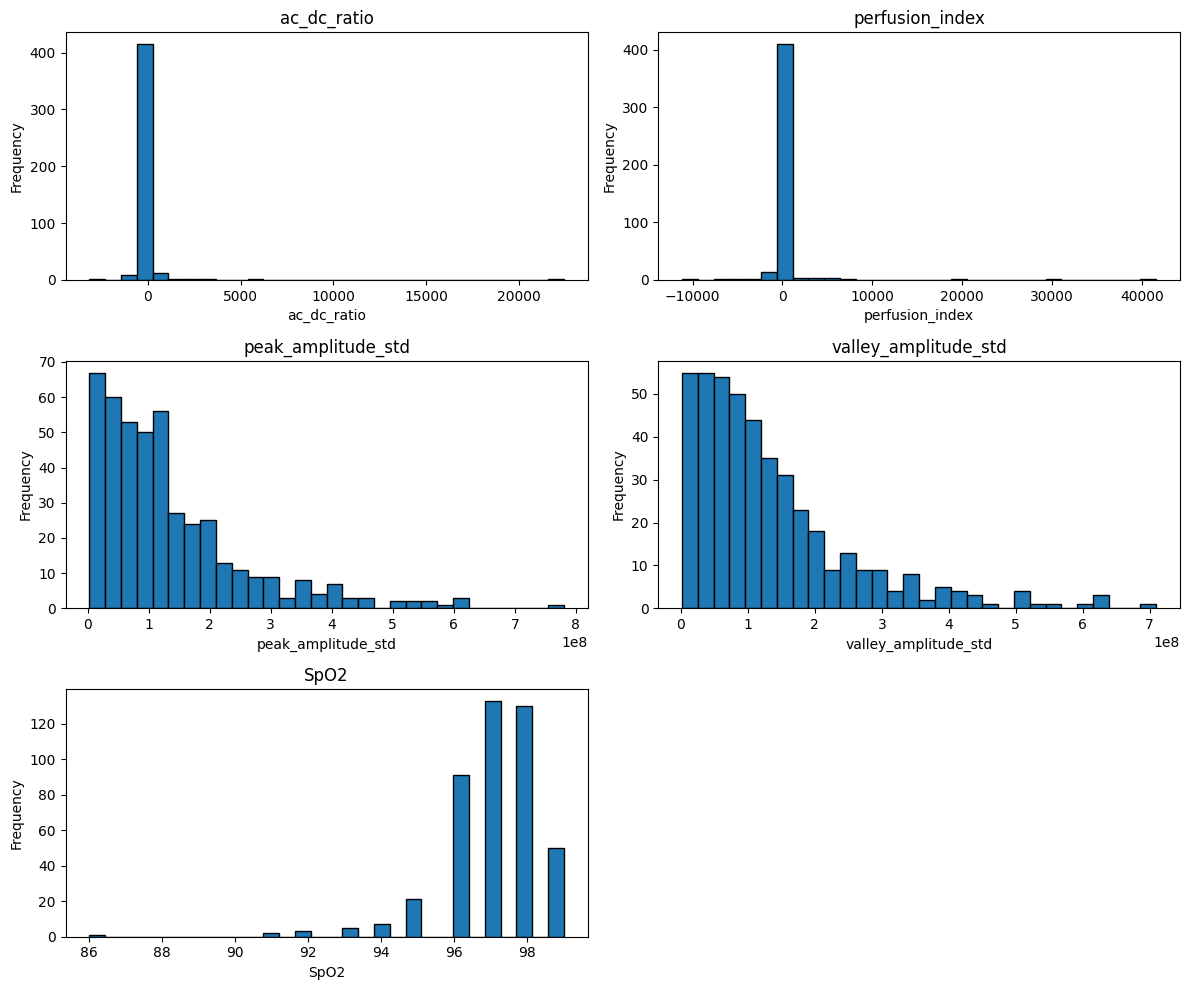

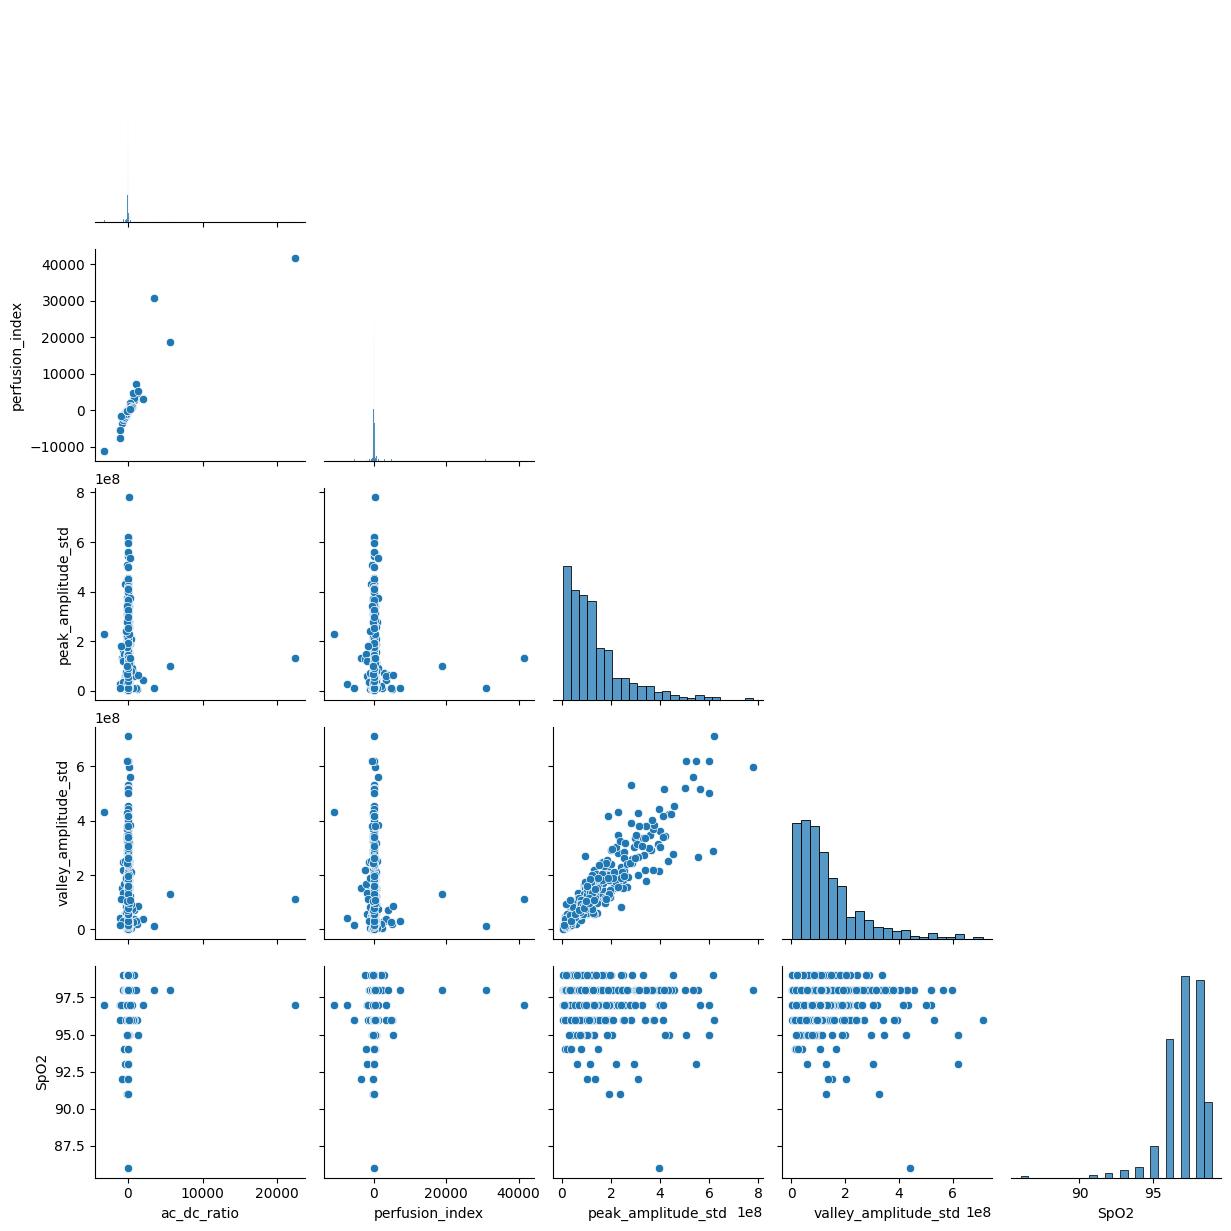

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming `features_df` is the DataFrame with updated features
# Histograms for individual features
features = ['ac_dc_ratio', 'perfusion_index', 'peak_amplitude_std', 'valley_amplitude_std', 'SpO2']

plt.figure(figsize=(12, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    plt.hist(features_df[feature], bins=30, edgecolor='black')
    plt.title(feature)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Scatter matrix to observe pairwise relationships
sns.pairplot(features_df, vars=features, diag_kind="hist", corner=True)
plt.show()


In [78]:
# Calculate the correlation matrix
correlation_matrix = features_df.corr()

# Display the correlation with SpO2
print("Correlation with SpO2:")
print(correlation_matrix['SpO2'].sort_values(ascending=False))


Correlation with SpO2:
SpO2                    1.000000
perfusion_index         0.040995
ac_dc_ratio             0.016542
peak_amplitude_std     -0.031889
valley_amplitude_std   -0.082160
Name: SpO2, dtype: float64


Feature Importances:
                Feature  Importance
3  valley_amplitude_std    0.293424
1       perfusion_index    0.275619
2    peak_amplitude_std    0.223219
0           ac_dc_ratio    0.207739


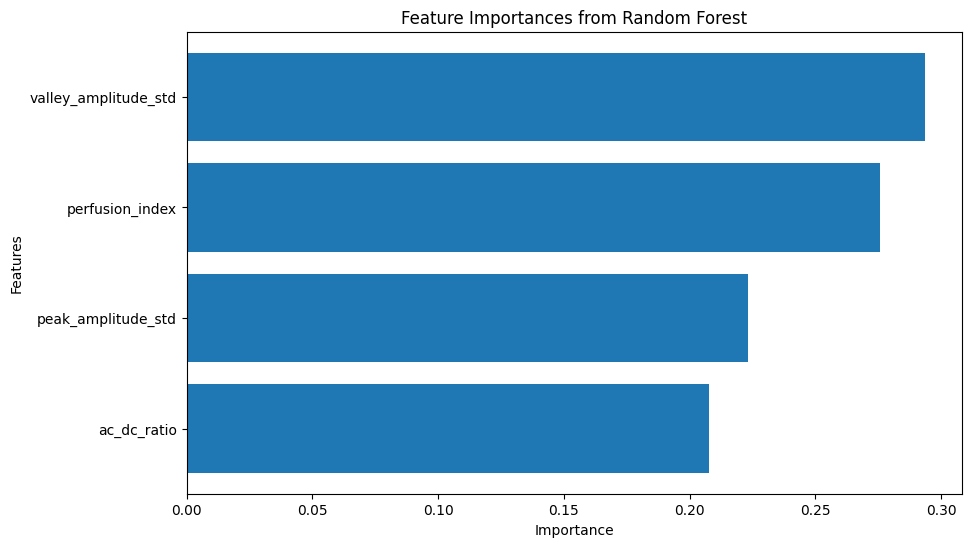

In [79]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Split the data into features and target
X = features_df.drop(columns=['SpO2'])
y = features_df['SpO2']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_

# Display feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances)

# Plot feature importances
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.show()


In [80]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = features_df.drop(columns=['SpO2']).values
y = features_df['SpO2'].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")


Training set shape: (354, 4), Testing set shape: (89, 4)


In [81]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Manually compute RMSE
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")


MAE: 1.31, RMSE: 2.09, R²: -0.08


In [82]:
from xgboost import XGBRegressor

# Train XGBoost Regressor
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Manually compute RMSE
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")


MAE: 1.32, RMSE: 2.09, R²: -0.14


In [83]:
import numpy as np

# Define function to handle outliers using IQR method
def handle_outliers(df, columns, method="cap"):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        if method == "cap":
            # Cap outliers at lower and upper bounds
            df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
            df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
        elif method == "remove":
            # Remove rows with outliers
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        elif method == "replace":
            # Replace outliers with median
            df[col] = np.where(df[col] < lower_bound, df[col].median(), df[col])
            df[col] = np.where(df[col] > upper_bound, df[col].median(), df[col])
    
    return df

# Apply the function to handle outliers
columns_to_check = ['ac_dc_ratio', 'perfusion_index', 'peak_amplitude_std', 'valley_amplitude_std']
features_df = handle_outliers(features_df, columns_to_check, method="cap")

# Display statistics after handling outliers
print("\nFeature Statistics After Handling Outliers:")
print(features_df.describe())



Feature Statistics After Handling Outliers:
       ac_dc_ratio  perfusion_index  peak_amplitude_std  valley_amplitude_std  \
count   443.000000       443.000000        4.430000e+02          4.430000e+02   
mean     -1.355533        -4.701178        1.276323e+08          1.264874e+08   
std      58.152553       171.662396        1.035905e+08          1.009345e+08   
min    -116.783637      -354.007575        2.808613e+06          1.368950e+06   
25%     -30.265147       -98.407745        4.685100e+07          4.924995e+07   
50%       2.512094        15.776884        1.019440e+08          9.897903e+07   
75%      27.413846        71.992141        1.789045e+08          1.789391e+08   
max     113.932336       327.591971        3.769849e+08          3.734728e+08   

             SpO2  
count  443.000000  
mean    97.040632  
std      1.439008  
min     86.000000  
25%     96.000000  
50%     97.000000  
75%     98.000000  
max     99.000000  


In [84]:
# Remove rows where SpO2 < 90
features_df = features_df[features_df['SpO2'] >= 90]

# Display the updated statistics and shape
print("\nUpdated Feature Statistics After Removing SpO2 < 90:")
print(features_df.describe())
print(f"\nUpdated Dataset Shape: {features_df.shape}")



Updated Feature Statistics After Removing SpO2 < 90:
       ac_dc_ratio  perfusion_index  peak_amplitude_std  valley_amplitude_std  \
count   442.000000       442.000000        4.420000e+02          4.420000e+02   
mean     -1.328381        -4.641517        1.270682e+08          1.259286e+08   
std      58.215637       171.852316        1.030243e+08          1.003606e+08   
min    -116.783637      -354.007575        2.808613e+06          1.368950e+06   
25%     -30.480634       -98.605463        4.678334e+07          4.910467e+07   
50%       2.668090        16.218380        1.017186e+08          9.880502e+07   
75%      27.437987        72.487612        1.775195e+08          1.784317e+08   
max     113.932336       327.591971        3.769849e+08          3.734728e+08   

             SpO2  
count  442.000000  
mean    97.065611  
std      1.341047  
min     91.000000  
25%     96.000000  
50%     97.000000  
75%     98.000000  
max     99.000000  

Updated Dataset Shape: (442, 5)


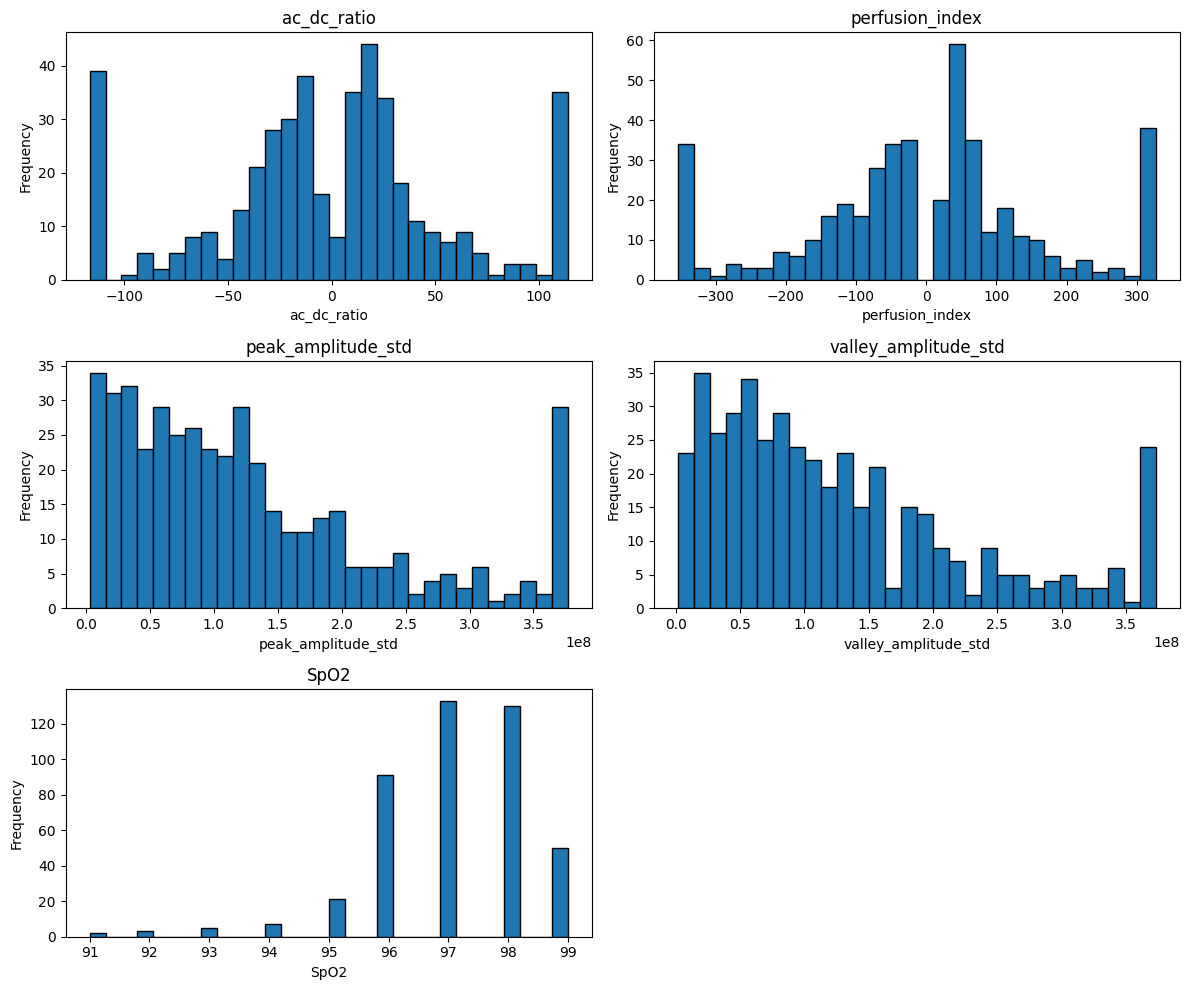

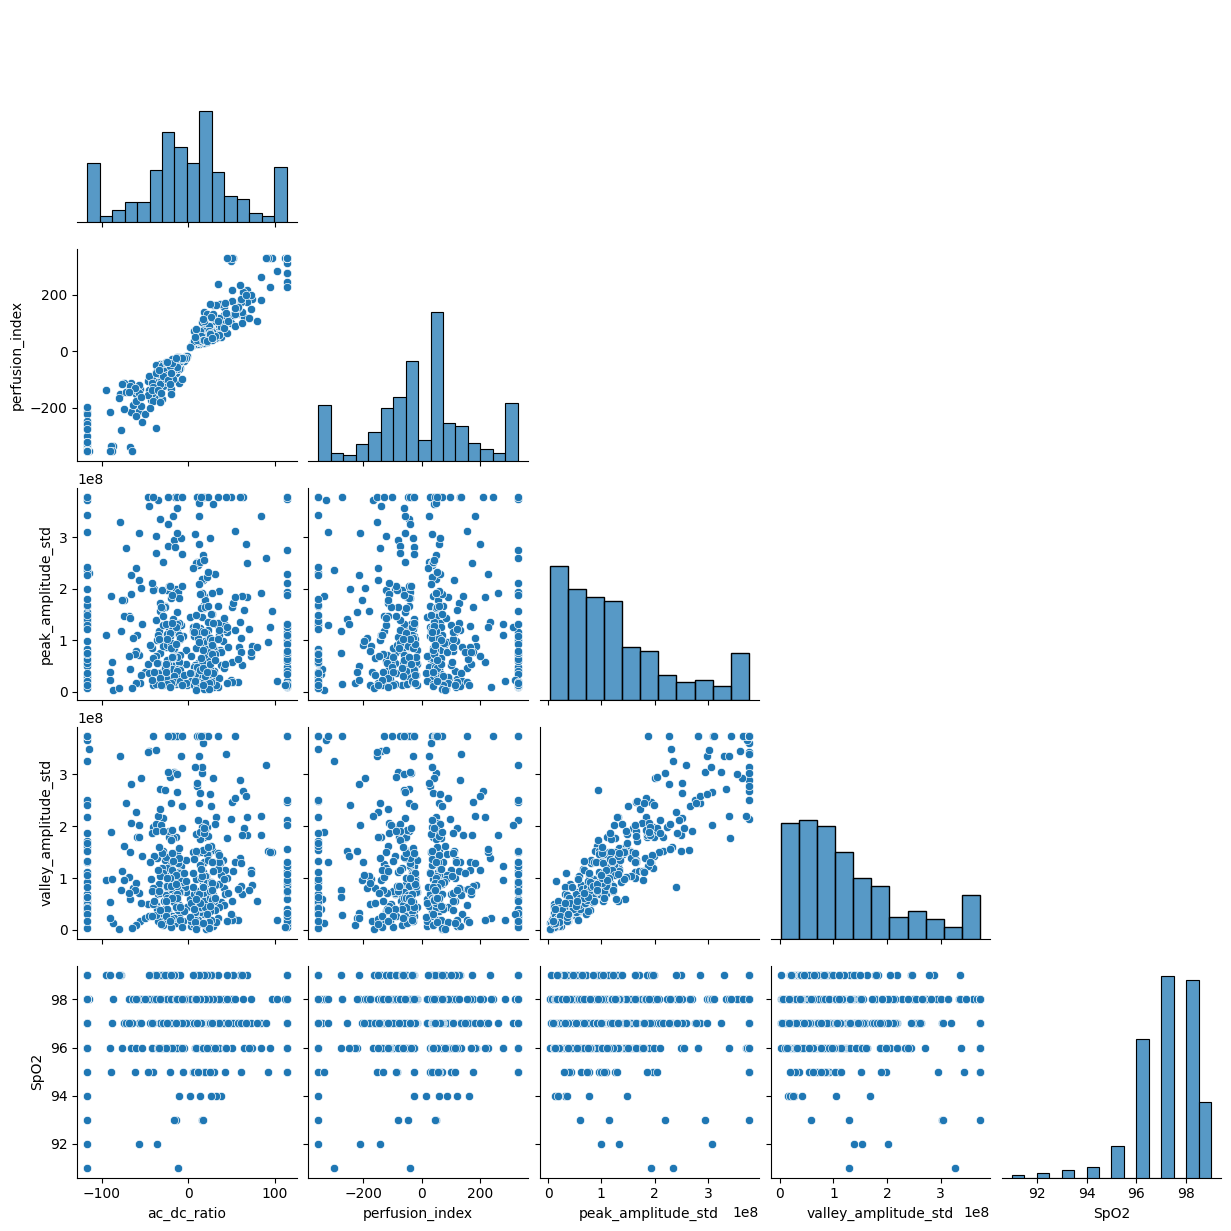

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming `features_df` is the DataFrame with updated features
# Histograms for individual features
features = ['ac_dc_ratio', 'perfusion_index', 'peak_amplitude_std', 'valley_amplitude_std', 'SpO2']

plt.figure(figsize=(12, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    plt.hist(features_df[feature], bins=30, edgecolor='black')
    plt.title(feature)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Scatter matrix to observe pairwise relationships
sns.pairplot(features_df, vars=features, diag_kind="hist", corner=True)
plt.show()


In [86]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights
unique_classes = np.unique(spo2_values)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=spo2_values
)

# Convert to dictionary for training
class_weight_dict = {int(cls): weight for cls, weight in zip(unique_classes, class_weights)}
print("Class Weights:", class_weight_dict)


Class Weights: {86: 44.3, 91: 22.15, 92: 14.766666666666667, 93: 8.86, 94: 6.328571428571428, 95: 2.1095238095238096, 96: 0.4868131868131868, 97: 0.3330827067669173, 98: 0.34076923076923077, 99: 0.886}


In [87]:
def augment_data(features, labels, target_class, num_samples):
    """
    Augment data for a target class by perturbing the features.
    """
    augmented_features = []
    augmented_labels = []
    
    # Filter data for the target class
    target_indices = np.where(labels == target_class)[0]
    original_samples = features[target_indices]
    
    # Generate new samples by adding random noise
    for _ in range(num_samples):
        idx = np.random.choice(len(original_samples))
        sample = original_samples[idx]
        noise = np.random.normal(0, 0.01, sample.shape)  # Add small random noise
        augmented_features.append(sample + noise)
        augmented_labels.append(target_class)
    
    return np.array(augmented_features), np.array(augmented_labels)

# Augment data for minority classes
minority_classes = [cls for cls in unique_classes if len(spo2_values[spo2_values == cls]) < 20]  # Example threshold
augmented_features = []
augmented_labels = []

for cls in minority_classes:
    num_samples_to_generate = 20 - len(spo2_values[spo2_values == cls])  # Target at least 20 samples per class
    new_features, new_labels = augment_data(engineered_features, spo2_values, cls, num_samples_to_generate)
    augmented_features.append(new_features)
    augmented_labels.append(new_labels)

# Combine augmented data with the original dataset
if augmented_features:
    augmented_features = np.vstack(augmented_features)
    augmented_labels = np.hstack(augmented_labels)
    engineered_features = np.vstack([engineered_features, augmented_features])
    spo2_values = np.hstack([spo2_values, augmented_labels])


In [88]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(engineered_features, spo2_values, test_size=0.2, random_state=42)

# Train the Random Forest model with class weights
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Manually compute RMSE
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")


MAE: 0.93, RMSE: 2.09, R²: 0.77


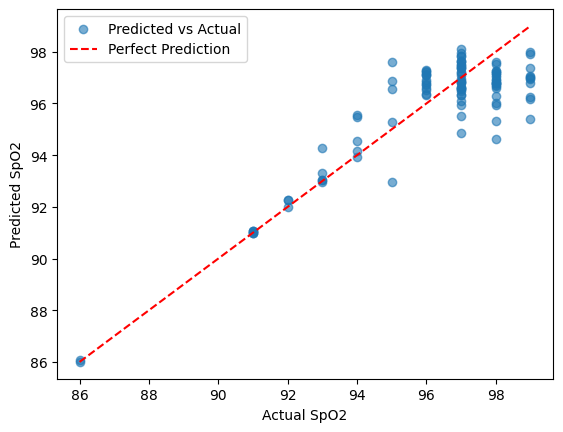

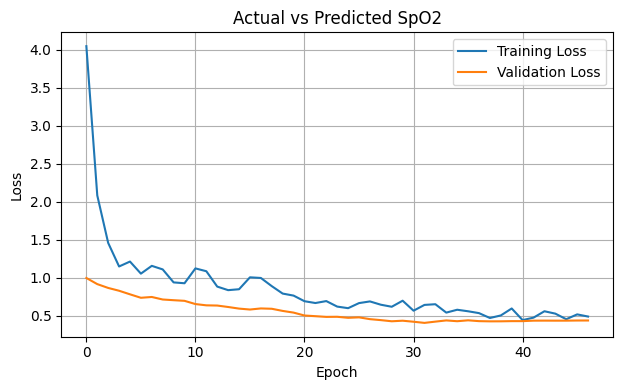

In [89]:
import matplotlib.pyplot as plt

# Plot actual vs predicted
plt.scatter(y_test, y_pred, alpha=0.6, label="Predicted vs Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Prediction")
plt.xlabel("Actual SpO2")
plt.ylabel("Predicted SpO2")
plt.legend()
# Create loss figure
plt.figure(figsize=(12, 4))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss') 
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.title("Actual vs Predicted SpO2")
plt.grid(True)
plt.show()


In [90]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define a set of hyperparameters to manually test
n_estimators = [50, 100, 150]
max_depth = [None, 10, 20, 30]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

# Initialize variables to store the best model and performance
best_model = None
best_params = None
best_mae = float("inf")

# Loop through all combinations of hyperparameters
for n in n_estimators:
    for depth in max_depth:
        for split in min_samples_split:
            for leaf in min_samples_leaf:
                # Train the model with the current set of hyperparameters
                rf = RandomForestRegressor(
                    n_estimators=n,
                    max_depth=depth,
                    min_samples_split=split,
                    min_samples_leaf=leaf,
                    random_state=42
                )
                rf.fit(X_train, y_train)
                
                # Predict on the test set
                y_pred = rf.predict(X_test)
                
                # Evaluate the model
                mae = mean_absolute_error(y_test, y_pred)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                r2 = r2_score(y_test, y_pred)
                
                # Check if this model is better than the previous best
                if mae < best_mae:
                    best_mae = mae
                    best_model = rf
                    best_params = {
                        "n_estimators": n,
                        "max_depth": depth,
                        "min_samples_split": split,
                        "min_samples_leaf": leaf
                    }
                    print(f"New Best Model: MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")
                    print(f"Params: n_estimators={n}, max_depth={depth}, min_samples_split={split}, min_samples_leaf={leaf}")

# Output the best model and parameters
print("\nBest Hyperparameters:", best_params)
y_pred = best_model.predict(X_test)
final_mae = mean_absolute_error(y_test, y_pred)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
final_r2 = r2_score(y_test, y_pred)

print(f"\nFinal Model Performance: MAE: {final_mae:.2f}, RMSE: {final_rmse:.2f}, R²: {final_r2:.2f}")


New Best Model: MAE: 0.93, RMSE: 1.22, R²: 0.77
Params: n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=1
New Best Model: MAE: 0.93, RMSE: 1.22, R²: 0.77
Params: n_estimators=50, max_depth=20, min_samples_split=2, min_samples_leaf=1
New Best Model: MAE: 0.93, RMSE: 1.21, R²: 0.77
Params: n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1
New Best Model: MAE: 0.92, RMSE: 1.21, R²: 0.77
Params: n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=1
New Best Model: MAE: 0.92, RMSE: 1.20, R²: 0.78
Params: n_estimators=150, max_depth=None, min_samples_split=2, min_samples_leaf=1
New Best Model: MAE: 0.92, RMSE: 1.21, R²: 0.78
Params: n_estimators=150, max_depth=10, min_samples_split=2, min_samples_leaf=1
New Best Model: MAE: 0.92, RMSE: 1.20, R²: 0.78
Params: n_estimators=150, max_depth=20, min_samples_split=2, min_samples_leaf=1

Best Hyperparameters: {'n_estimators': 150, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_l

c:\Users\Tiddie Destroyer\anaconda3\envs\ML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


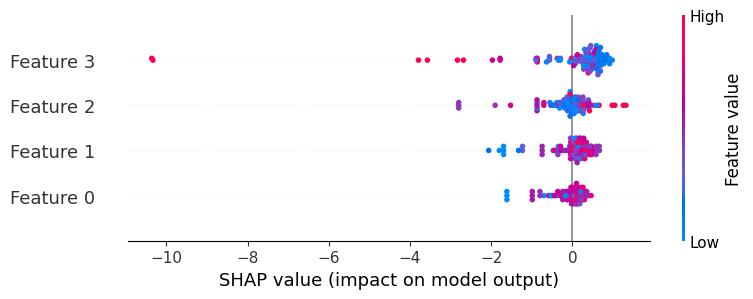

In [91]:
import shap

# Create a SHAP explainer
explainer = shap.Explainer(best_model, X_train)

# Get SHAP values
shap_values = explainer(X_test)

# Plot summary
shap.summary_plot(shap_values, X_test)


In [92]:
# Predict on the test set
y_pred = best_model.predict(X_test)

# Convert predictions and actual values back to original scale (if applicable)
# Example: If you've used MinMaxScaler or StandardScaler, inverse transform them
# y_pred = target_scaler.inverse_transform(y_pred.reshape(-1, 1))
# y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Print some predictions vs actuals for comparison
for i in range(10):  # Adjust range as needed
    print(f"Actual: {y_test[i]:.2f}, Predicted: {y_pred[i]:.2f}")

# Evaluate model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Manually compute RMSE
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


Actual: 96.00, Predicted: 96.23
Actual: 97.00, Predicted: 96.29
Actual: 97.00, Predicted: 97.83
Actual: 99.00, Predicted: 95.37
Actual: 86.00, Predicted: 86.00
Actual: 96.00, Predicted: 96.78
Actual: 94.00, Predicted: 94.49
Actual: 92.00, Predicted: 92.00
Actual: 98.00, Predicted: 96.96
Actual: 96.00, Predicted: 96.82
Model Performance:
MAE: 0.92
RMSE: 2.09
R²: 0.78


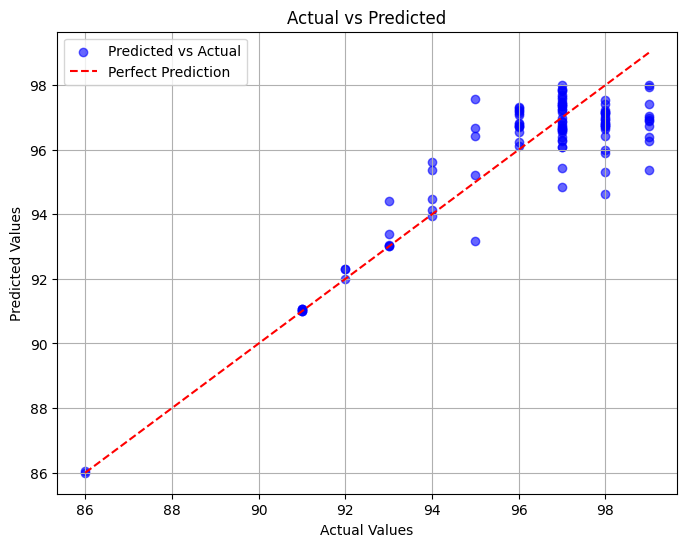

In [93]:
import matplotlib.pyplot as plt

# Scatter plot for predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.legend()
plt.grid()
plt.show()


In [94]:
import joblib

# Save the model
joblib.dump(best_model, 'optimized_rf_model.pkl')

# Load the model
loaded_model = joblib.load('optimized_rf_model.pkl')

# Test the loaded model
y_loaded_pred = loaded_model.predict(X_test)


HERE ONWARDS IS GLYCAEMIA

Glycaemia Distribution Analysis:
count    443.000000
mean       0.244351
std        0.206533
min        0.000000
25%        0.103093
50%        0.164948
75%        0.329897
max        1.000000
Name: Glycaemia, dtype: float64


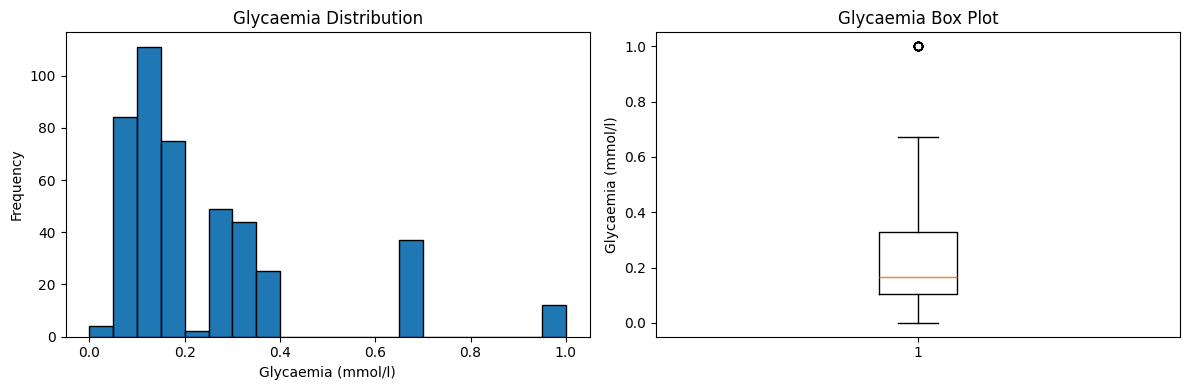


Correlations with Glycaemia:
Glycaemia    1.000000
HR           0.402276
SpO2         0.001363
Name: Glycaemia, dtype: float64


In [95]:
# Load and analyze Glycaemia data
print("Glycaemia Distribution Analysis:")
print(df['Glycaemia'].describe())

plt.figure(figsize=(12, 4))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(df['Glycaemia'], bins=20, edgecolor='black')
plt.title('Glycaemia Distribution')
plt.xlabel('Glycaemia (mmol/l)')
plt.ylabel('Frequency')

# Box plot
plt.subplot(1, 2, 2)
plt.boxplot(df['Glycaemia'])
plt.title('Glycaemia Box Plot')
plt.ylabel('Glycaemia (mmol/l)')

plt.tight_layout()
plt.show()

# Check for correlations between Glycaemia and other vital signs
correlations = df[['Glycaemia', 'HR', 'SpO2']].corr()
print("\nCorrelations with Glycaemia:")
print(correlations['Glycaemia'])

In [96]:
def extract_glycaemia_features(signal):
    """Extract features specifically relevant for Glycaemia prediction"""
    features = {}
    
    # Normalize signal
    signal = np.array(signal)
    signal = (signal - np.mean(signal)) / (np.std(signal) + 1e-10)
    
    # Find peaks and valleys
    peaks, _ = find_peaks(signal, distance=10)
    valleys, _ = find_peaks(-signal, distance=10)
    
    if len(peaks) > 0 and len(valleys) > 0:
        peak_heights = signal[peaks]
        valley_depths = signal[valleys]
        
        # Time domain features
        features.update({
            'mean_peak_height': np.mean(peak_heights),
            'std_peak_height': np.std(peak_heights),
            'mean_valley_depth': np.mean(valley_depths),
            'peak_valley_ratio': np.mean(peak_heights) / abs(np.mean(valley_depths)),
            'waveform_length': np.sum(np.abs(np.diff(signal))),
            'peak_frequency': len(peaks) / len(signal),
            
            # Statistical features
            'signal_mean': np.mean(signal),
            'signal_std': np.std(signal),
            'signal_skew': skew(signal),
            'signal_kurtosis': kurtosis(signal)
        })
        
        # Add intervals between peaks
        if len(peaks) > 1:
            peak_intervals = np.diff(peaks)
            features.update({
                'mean_peak_interval': np.mean(peak_intervals),
                'std_peak_interval': np.std(peak_intervals)
            })
        
    else:
        # Default values if no peaks found
        features.update({
            'mean_peak_height': 0,
            'std_peak_height': 0,
            'mean_valley_depth': 0,
            'peak_valley_ratio': 0,
            'waveform_length': np.sum(np.abs(np.diff(signal))),
            'peak_frequency': 0,
            'signal_mean': np.mean(signal),
            'signal_std': np.std(signal),
            'signal_skew': skew(signal),
            'signal_kurtosis': kurtosis(signal),
            'mean_peak_interval': 0,
            'std_peak_interval': 0
        })
    
    return features

def prepare_glycaemia_data(df):
    """Prepare data for Glycaemia prediction"""
    # Extract features from PPG signals
    features_list = []
    ppg_signals = []
    
    for signal_str in df['PPG_SIGNAL']:
        signal = np.array(eval(signal_str))
        # Normalize signal
        signal = (signal - np.mean(signal)) / (np.std(signal) + 1e-10)
        ppg_signals.append(signal)
        # Extract features
        features = extract_glycaemia_features(signal)
        features_list.append(list(features.values()))
    
    # Convert to numpy arrays
    ppg_signals = np.array(ppg_signals)
    features = np.array(features_list)
    
    # Reshape signals
    ppg_signals = ppg_signals.reshape(-1, 300, 1)
    
    # Scale features
    feature_scaler = StandardScaler()
    scaled_features = feature_scaler.fit_transform(features)
    
    # Scale Glycaemia values
    target_scaler = StandardScaler()
    targets = target_scaler.fit_transform(df['Glycaemia'].values.reshape(-1, 1))
    
    return {
        'ppg_signals': ppg_signals,
        'engineered_features': scaled_features,
        'targets': targets,
        'feature_scaler': feature_scaler,
        'target_scaler': target_scaler
    }

Epoch 1/100
9/9 [==============================] - 3s 74ms/step - loss: 3.3047 - mae: 1.3824 - val_loss: 0.8575 - val_mae: 0.7786 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 0s 24ms/step - loss: 1.9318 - mae: 1.0510 - val_loss: 0.8186 - val_mae: 0.7580 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - 0s 24ms/step - loss: 1.4695 - mae: 0.8889 - val_loss: 0.7960 - val_mae: 0.7463 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - 0s 24ms/step - loss: 1.0958 - mae: 0.8032 - val_loss: 0.7829 - val_mae: 0.7392 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - 0s 25ms/step - loss: 1.0005 - mae: 0.7728 - val_loss: 0.7722 - val_mae: 0.7334 - lr: 0.0010
Epoch 6/100
9/9 [==============================] - 0s 24ms/step - loss: 0.9966 - mae: 0.7614 - val_loss: 0.7593 - val_mae: 0.7246 - lr: 0.0010
Epoch 7/100
9/9 [==============================] - 0s 24ms/step - loss: 0.9593 - mae: 0.7666 - val_loss: 0.7473 - val_mae: 0.7158 - lr: 0.0010

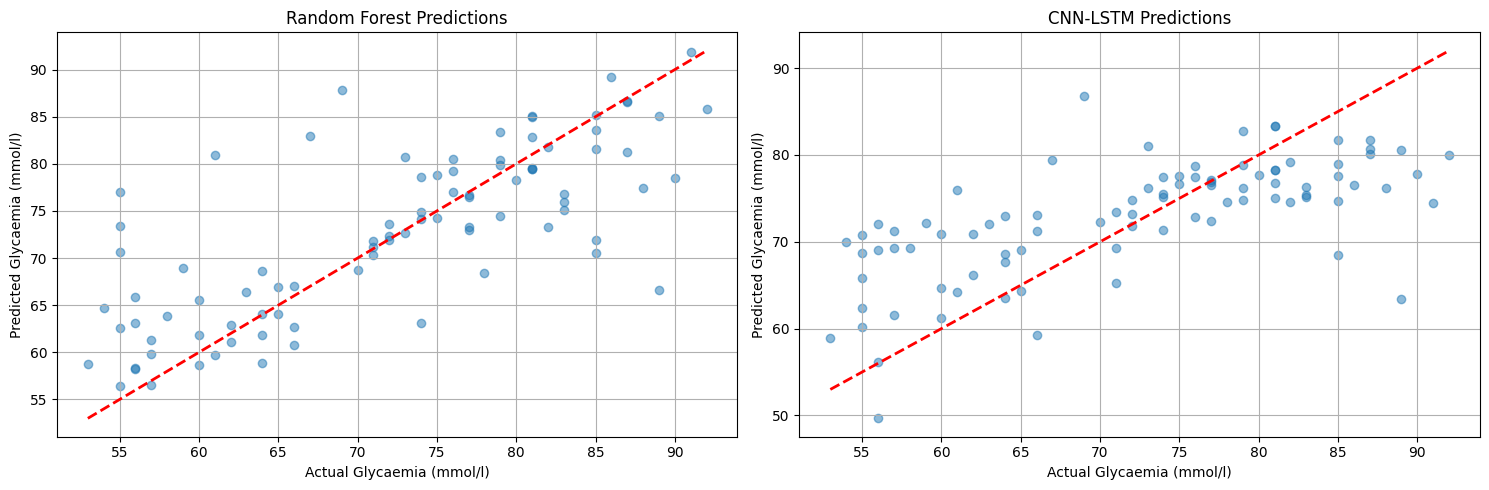


Random Forest Results:
R² Score: 0.5685
MAE: 4.9072
RMSE: 7.2414

CNN-LSTM Results:
R² Score: 0.4412
MAE: 6.4657
RMSE: 8.2405


In [97]:
# 1. Random Forest Implementation
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    prepared_data['engineered_features'],
    prepared_data['targets'],
    test_size=0.2,
    random_state=42
)

# Train Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

rf_model.fit(X_train, y_train)

# RF Predictions
rf_predictions = rf_model.predict(X_test)
rf_predictions_original = prepared_data['target_scaler'].inverse_transform(rf_predictions.reshape(-1, 1))
y_test_original = prepared_data['target_scaler'].inverse_transform(y_test.reshape(-1, 1))

# 2. CNN-LSTM Implementation
def create_glycaemia_model(sequence_length=300, n_engineered_features=12):
    # PPG signal input
    ppg_input = Input(shape=(sequence_length, 1), name='ppg_input')
    
    # CNN layers
    x = Conv1D(32, kernel_size=5, padding='same')(ppg_input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    conv1 = x
    x = MaxPooling1D(2)(x)
    
    x = Conv1D(64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2)(x)
    
    # Residual connection
    x_upsampled = tf.keras.layers.UpSampling1D(4)(x)
    x = concatenate([conv1, x_upsampled])
    
    # LSTM with attention
    x = LSTM(64, return_sequences=True)(x)
    
    # Self-attention
    attention = Dense(1, activation='tanh')(x)
    attention = tf.keras.layers.Softmax(axis=1)(attention)
    x = tf.keras.layers.Multiply()([x, attention])
    x = GlobalAveragePooling1D()(x)
    
    # Engineered features input
    engineered_input = Input(shape=(n_engineered_features,), name='engineered_input')
    engineered_x = Dense(32, activation='relu')(engineered_input)
    engineered_x = BatchNormalization()(engineered_x)
    engineered_x = Dense(16, activation='relu')(engineered_x)
    
    # Combine features
    combined = concatenate([x, engineered_x])
    
    # Final dense layers
    x = Dense(32, activation='relu')(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    output = Dense(1)(x)
    
    model = Model(inputs=[ppg_input, engineered_input], outputs=output)
    return model

# Create and compile model
glycaemia_model = create_glycaemia_model(
    n_engineered_features=prepared_data['engineered_features'].shape[1]
)

glycaemia_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Train the model
history = glycaemia_model.fit(
    [train_data['ppg_signals'], train_data['engineered_features']],
    train_data['targets'],
    validation_data=(
        [test_data['ppg_signals'], test_data['engineered_features']],
        test_data['targets']
    ),
    epochs=100,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6
        )
    ],
    verbose=1
)

# Plot and compare results
plt.figure(figsize=(15, 5))

# RF Results
plt.subplot(1, 2, 1)
plt.scatter(y_test_original, rf_predictions_original, alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], 
         'r--', lw=2)
plt.xlabel('Actual Glycaemia (mmol/l)')
plt.ylabel('Predicted Glycaemia (mmol/l)')
plt.title('Random Forest Predictions')
plt.grid(True)

# CNN-LSTM Results
plt.subplot(1, 2, 2)
dl_predictions = glycaemia_model.predict([test_data['ppg_signals'], test_data['engineered_features']])
dl_predictions_original = prepared_data['target_scaler'].inverse_transform(dl_predictions)
plt.scatter(test_actual_original, dl_predictions_original, alpha=0.5)
plt.plot([test_actual_original.min(), test_actual_original.max()], 
         [test_actual_original.min(), test_actual_original.max()], 
         'r--', lw=2)
plt.xlabel('Actual Glycaemia (mmol/l)')
plt.ylabel('Predicted Glycaemia (mmol/l)')
plt.title('CNN-LSTM Predictions')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print metrics for both models
print("\nRandom Forest Results:")
print(f"R² Score: {r2_score(y_test_original, rf_predictions_original):.4f}")
print(f"MAE: {mean_absolute_error(y_test_original, rf_predictions_original):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_original, rf_predictions_original)):.4f}")

print("\nCNN-LSTM Results:")
print(f"R² Score: {r2_score(test_actual_original, dl_predictions_original):.4f}")
print(f"MAE: {mean_absolute_error(test_actual_original, dl_predictions_original):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(test_actual_original, dl_predictions_original)):.4f}")


Random Forest Results:
R² Score: 0.6118
MAE: 4.9848
RMSE: 6.8683


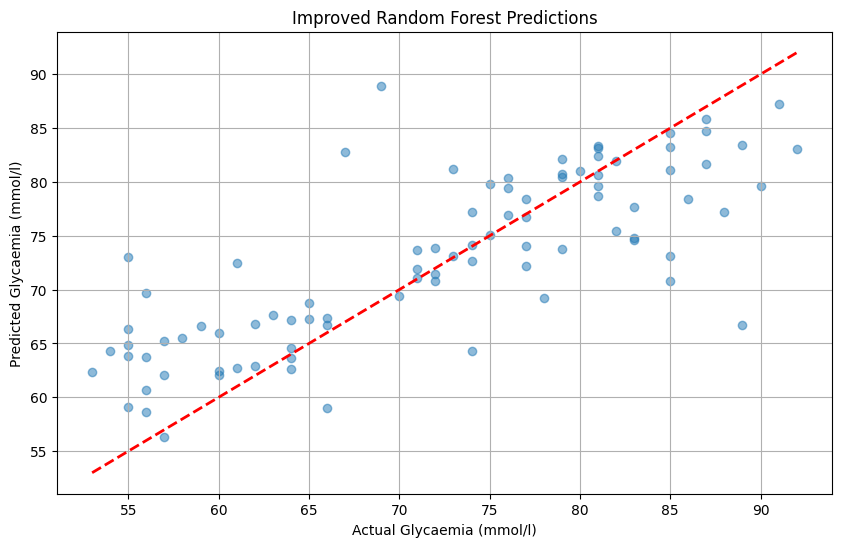

In [98]:
# 1. First, let's implement the enhanced features
def extract_enhanced_glycaemia_features(signal):
    features = {}
    signal = np.array(signal)
    signal = (signal - np.mean(signal)) / (np.std(signal) + 1e-10)
    
    # Find peaks and valleys
    peaks, _ = find_peaks(signal, height=0, distance=10)
    valleys, _ = find_peaks(-signal, height=0, distance=10)
    
    if len(peaks) > 0 and len(valleys) > 0:
        peak_heights = signal[peaks]
        valley_depths = signal[valleys]
        
        # Core features (most important for glycaemia)
        features.update({
            'peak_height_mean': np.mean(peak_heights),
            'peak_height_std': np.std(peak_heights),
            'valley_depth_mean': np.mean(valley_depths),
            'peak_valley_ratio': np.mean(peak_heights) / abs(np.mean(valley_depths)),
            'waveform_length': np.sum(np.abs(np.diff(signal))),
            'peak_frequency': len(peaks) / len(signal),
            'signal_mean': np.mean(signal),
            'signal_std': np.std(signal),
            'signal_skew': skew(signal),
            'area_under_curve': np.trapz(signal)
        })
        
        # Interval features
        if len(peaks) > 1:
            peak_intervals = np.diff(peaks)
            features.update({
                'peak_interval_mean': np.mean(peak_intervals),
                'peak_interval_std': np.std(peak_intervals)
            })
        else:
            features.update({
                'peak_interval_mean': 0,
                'peak_interval_std': 0
            })
            
    else:
        # Default values
        features.update(dict.fromkeys([
            'peak_height_mean', 'peak_height_std', 'valley_depth_mean',
            'peak_valley_ratio', 'waveform_length', 'peak_frequency',
            'signal_mean', 'signal_std', 'signal_skew', 'area_under_curve',
            'peak_interval_mean', 'peak_interval_std'
        ], 0))
    
    return features

# 2. Optimized Random Forest (without GridSearch)
rf_model = RandomForestRegressor(
    n_estimators=200,          # More trees for better stability
    max_depth=15,              # Limit depth to prevent overfitting
    min_samples_split=5,       # Require more samples to split
    min_samples_leaf=2,        # Require more samples in leaves
    max_features='sqrt',       # Use sqrt of features for each split
    random_state=42
)

# 3. Train and evaluate
rf_model.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)
rf_predictions_original = prepared_data['target_scaler'].inverse_transform(rf_predictions.reshape(-1, 1))
y_test_original = prepared_data['target_scaler'].inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
print("\nRandom Forest Results:")
print(f"R² Score: {r2_score(y_test_original, rf_predictions_original):.4f}")
print(f"MAE: {mean_absolute_error(y_test_original, rf_predictions_original):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_original, rf_predictions_original)):.4f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, rf_predictions_original, alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], 
         'r--', lw=2)
plt.xlabel('Actual Glycaemia (mmol/l)')
plt.ylabel('Predicted Glycaemia (mmol/l)')
plt.title('Improved Random Forest Predictions')
plt.grid(True)
plt.show()

# Feature importance analysis
# Feature importance analysis
feature_names = list(extract_enhanced_glycaemia_features(eval(df['PPG_SIGNAL'].iloc[0])).keys())


In [99]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Reverse scaling predictions and targets
y_pred_original = prepared_data['target_scaler'].inverse_transform(rf_predictions.reshape(-1, 1))
y_test_original = prepared_data['target_scaler'].inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics on original glycaemia values
mae_original = mean_absolute_error(y_test_original, y_pred_original)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2_original = r2_score(y_test_original, y_pred_original)

print(f"MAE (Original Scale): {mae_original:.2f}")
print(f"RMSE (Original Scale): {rmse_original:.2f}")
print(f"R² (Original Scale): {r2_original:.2f}")


MAE (Original Scale): 4.98
RMSE (Original Scale): 6.87
R² (Original Scale): 0.61


In [100]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from scipy.signal import find_peaks

# Use the `extract_glycaemia_features` function defined earlier

def prepare_glycaemia_dataframe(df):
    """Prepare the glycaemia dataset with PPG signals and engineered features."""
    engineered_features = []
    ppg_signals = []

    for idx, signal_str in enumerate(df['PPG_SIGNAL']):
        try:
            # Convert string to array
            signal = np.array(eval(signal_str))

            # Normalize signal
            signal = (signal - np.mean(signal)) / (np.std(signal) + 1e-10)
            ppg_signals.append(signal)

            # Extract features
            features = extract_glycaemia_features(signal)
            engineered_features.append(features)

        except Exception as e:
            print(f"Error processing row {idx}: {e}")

    # Convert features to DataFrame
    features_df = pd.DataFrame(engineered_features)

    # Combine PPG_SIGNAL, engineered_features, and Glycaemia into a single DataFrame
    processed_df = pd.concat([
        df.reset_index(drop=True)['PPG_SIGNAL'],  # Keep original PPG_SIGNAL
        features_df,                             # Engineered features
        df.reset_index(drop=True)['Glycaemia']   # Glycaemia ground truth
    ], axis=1)

    return processed_df

# Process the original DataFrame
processed_df = prepare_glycaemia_dataframe(df)

# Display the processed DataFrame
print(processed_df.head())


                                          PPG_SIGNAL  mean_peak_height  \
0  [228847219.5075, 238784328.7182, 340015569.347...          0.243037   
1  [743662069.948, 733520310.6899999, 736382094.2...          0.233386   
2  [-305872512.4, -310000110.6992, -316695693.608...          0.289123   
3  [-834906497.436, -945382102.8168, -1061351904....          0.470201   
4  [-84126148.1368, -94588051.0212, -86687758.225...          0.410753   

   std_peak_height  mean_valley_depth  peak_valley_ratio  waveform_length  \
0         1.181148          -0.368380           0.659745        27.433531   
1         0.956648          -0.117384           1.988219         9.789214   
2         0.928245          -0.188856           1.530918         9.260361   
3         1.192973          -0.565833           0.830989        34.618911   
4         1.098817          -0.408395           1.005774        26.719637   

   peak_frequency   signal_mean  signal_std  signal_skew  signal_kurtosis  \
0        0.0600

In [101]:
processed_df

,PPG_SIGNAL,mean_peak_height,std_peak_height,mean_valley_depth,peak_valley_ratio,waveform_length,peak_frequency,signal_mean,signal_std,signal_skew,signal_kurtosis,mean_peak_interval,std_peak_interval,Glycaemia
0,"[228847219.5075, 238784328.7182, 340015569.347...",0.243037,1.181148,-0.368380,0.659745,27.433531,0.060000,-9.473903e-17,1.0,-0.986388,0.458166,16.470588,5.791654,0.329897
1,"[743662069.948, 733520310.6899999, 736382094.2...",0.233386,0.956648,-0.117384,1.988219,9.789214,0.060000,0.000000e+00,1.0,0.023377,-1.534638,17.294118,5.757498,0.329897
2,"[-305872512.4, -310000110.6992, -316695693.608...",0.289123,0.928245,-0.188856,1.530918,9.260361,0.043333,4.736952e-17,1.0,-0.837434,-1.140740,22.916667,5.453719,0.329897
3,"[-834906497.436, -945382102.8168, -1061351904....",0.470201,1.192973,-0.565833,0.830989,34.618911,0.056667,4.736952e-17,1.0,-0.182140,-0.723556,18.000000,6.164414,0.329897
4,"[-84126148.1368, -94588051.0212, -86687758.225...",0.410753,1.098817,-0.408395,1.005774,26.719637,0.050000,4.736952e-17,1.0,0.241049,-0.841008,20.285714,3.862430,0.329897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,"[548637801.866, 327575669.162, 169676945.4744,...",1.256006,0.631637,-0.877055,1.432071,58.324837,0.043333,-4.736952e-17,1.0,0.210596,-0.730687,23.000000,1.224745,0.670103
439,"[-264877520.92, -358091661.42999995, -39337669...",1.160214,0.689972,-0.828746,1.399962,50.543230,0.043333,4.736952e-17,1.0,0.073814,-0.801843,23.083333,0.276385,0.670103
440,"[-12556717.524, -95959615.8645, -128263649.836...",1.020485,0.879942,-0.794141,1.285017,47.630852,0.043333,-4.736952e-17,1.0,-0.617142,0.326522,22.666667,0.471405,0.670103
441,"[-332481309.194, -322933024.9215, -311334372.2...",1.408230,0.572370,-0.969869,1.451980,62.847806,0.043333,0.000000e+00,1.0,0.093075,-0.616709,22.500000,0.645497,0.670103


In [164]:
processed_df.to_csv('glycaemia_features_dataset.csv', index=False)


In [181]:
from sklearn.model_selection import train_test_split

# Extract engineered features and Glycaemia
X = processed_df.drop(['PPG_SIGNAL', 'Glycaemia'], axis=1).values  # Features
y = processed_df['Glycaemia'].values  # Target

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train)}, Testing set size: {len(X_test)}")


Training set size: 354, Testing set size: 89


In [166]:
import numpy as np

def augment_samples(X, y, target_value, factor=0.1):
    """Augments samples for a specific target value."""
    indices = np.where(y == target_value)[0]
    augmented_X = []
    augmented_y = []

    for idx in indices:
        for _ in range(5):  # Augment each sample 5 times
            noise = np.random.normal(0, factor * np.std(X[idx]), X[idx].shape)
            augmented_X.append(X[idx] + noise)
            augmented_y.append(target_value)

    return np.array(augmented_X), np.array(augmented_y)

# Augment for underrepresented values
augmented_X, augmented_y = augment_samples(X_train, y_train, target_value=4.5)
X_train = np.vstack([X_train, augmented_X])
y_train = np.hstack([y_train, augmented_y])


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 12 and the array at index 1 has size 0

In [182]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")


MAE: 0.11, RMSE: 0.14, R²: 0.63


MAE: 0.106
R²: 0.631


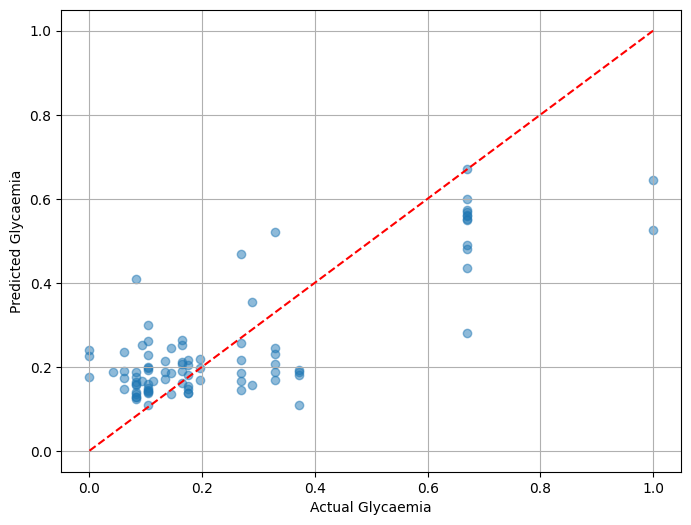

In [204]:
rf_model = RandomForestRegressor(
    n_estimators=1500,          # More trees for stability
    max_depth=20,              # Prevent overfitting
    min_samples_split=10,       # More samples per split
    min_samples_leaf=5,        # More samples per leaf
    max_features=0.7,          # Use 70% of features per split
    random_state=42
)

# Add feature scaling if not already done
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model.fit(X_train_scaled, y_train)
y_pred = rf_model.predict(X_test_scaled)

# Print metrics
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"R²: {r2_score(y_test, y_pred):.3f}")

# Plot predictions vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Glycaemia')
plt.ylabel('Predicted Glycaemia')
plt.grid(True)
plt.show()

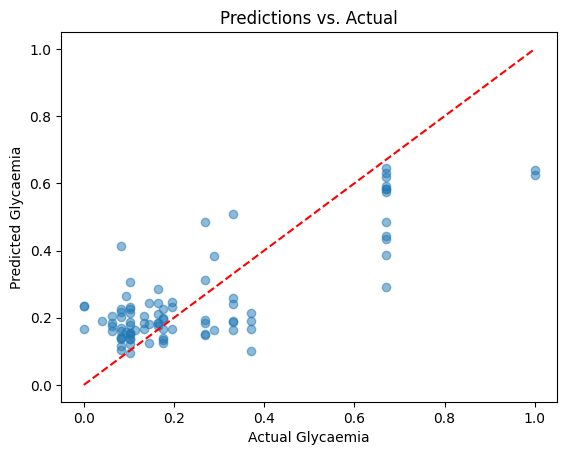

In [168]:
import matplotlib.pyplot as plt

# Visualize predictions
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Glycaemia")
plt.ylabel("Predicted Glycaemia")
plt.title("Predictions vs. Actual")
plt.show()


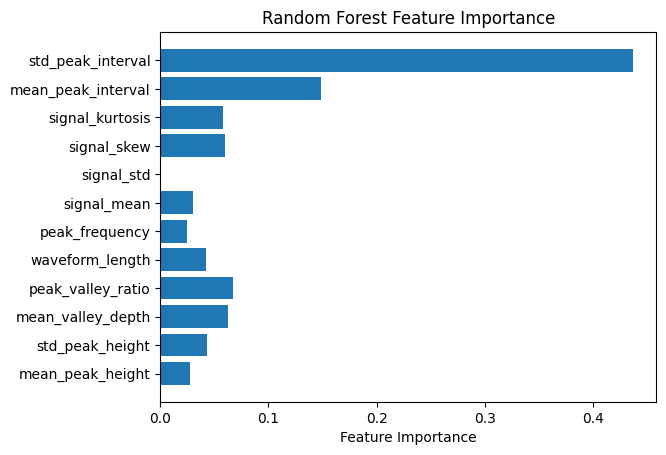

In [169]:
# Random Forest Feature Importance
importances = rf_model.feature_importances_
feature_names = processed_df.columns[1:-1]  # Exclude 'PPG_SIGNAL' and 'Glycaemia'
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()


In [170]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define the optimized model
rf_optimized_model = RandomForestRegressor(
    n_estimators=300,       # Increased number of trees
    max_depth=20,           # Limit the depth to prevent overfitting
    min_samples_split=5,    # Require more samples to split
    min_samples_leaf=2,     # Require more samples in leaf nodes
    max_features='sqrt',    # Use sqrt(features) for splitting
    random_state=42
)

# Train the enhanced model
rf_optimized_model.fit(X_train, y_train)

# Make predictions
rf_optimized_predictions = rf_optimized_model.predict(X_test)

# Convert predictions back to the original scale
rf_optimized_predictions_original = prepared_data['target_scaler'].inverse_transform(
    rf_optimized_predictions.reshape(-1, 1)
)
y_test_original = prepared_data['target_scaler'].inverse_transform(y_test.reshape(-1, 1))

# Evaluate the enhanced model
mae = mean_absolute_error(y_test_original, rf_optimized_predictions_original)
rmse = np.sqrt(mean_squared_error(y_test_original, rf_optimized_predictions_original))
r2 = r2_score(y_test_original, rf_optimized_predictions_original)

print(f"Enhanced Random Forest Results:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


Enhanced Random Forest Results:
MAE: 1.27
RMSE: 1.62
R²: 0.58


In [171]:
# Get feature importances from the model
feature_importances = rf_optimized_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
selected_features = [feature_names[i] for i in sorted_indices[:10]]  # Top 10 features

print(f"Selected Features: {selected_features}")


Selected Features: ['std_peak_interval', 'mean_peak_height', 'std_peak_height', 'mean_peak_interval', 'mean_valley_depth', 'waveform_length', 'signal_skew', 'peak_valley_ratio', 'signal_kurtosis', 'peak_frequency']


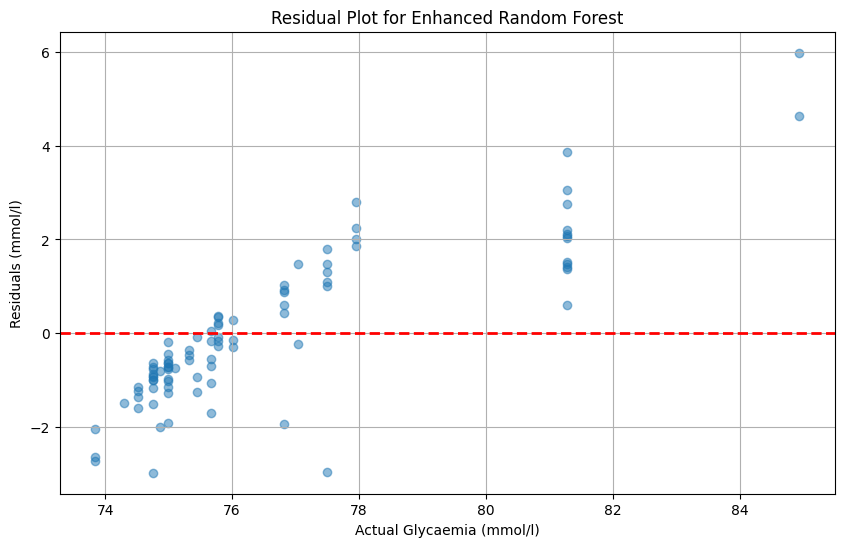

In [172]:
# Calculate residuals
residuals = y_test_original - rf_optimized_predictions_original

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Actual Glycaemia (mmol/l)')
plt.ylabel('Residuals (mmol/l)')
plt.title('Residual Plot for Enhanced Random Forest')
plt.grid(True)
plt.show()


In [173]:
from sklearn.ensemble import GradientBoostingRegressor

# Define a Gradient Boosting model
gb_model = GradientBoostingRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

# Train the model
gb_model.fit(X_train, y_train)

# Predict and evaluate
gb_predictions = gb_model.predict(X_test)
gb_predictions_original = prepared_data['target_scaler'].inverse_transform(
    gb_predictions.reshape(-1, 1)
)

print(f"Gradient Boosting Results:")
print(f"MAE: {mean_absolute_error(y_test_original, gb_predictions_original):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_original, gb_predictions_original)):.2f}")
print(f"R²: {r2_score(y_test_original, gb_predictions_original):.2f}")


Gradient Boosting Results:
MAE: 1.25
RMSE: 1.63
R²: 0.58


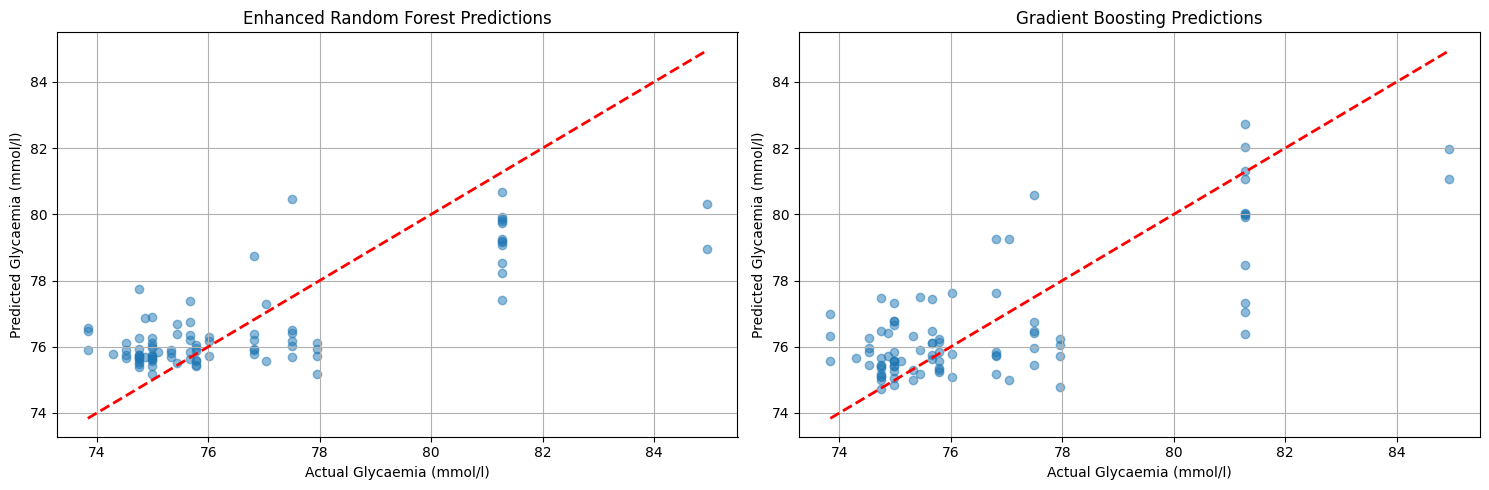

In [174]:
# Plot predictions
plt.figure(figsize=(15, 5))

# Enhanced Random Forest
plt.subplot(1, 2, 1)
plt.scatter(y_test_original, rf_optimized_predictions_original, alpha=0.5)
plt.plot(
    [y_test_original.min(), y_test_original.max()],
    [y_test_original.min(), y_test_original.max()],
    'r--', lw=2
)
plt.xlabel('Actual Glycaemia (mmol/l)')
plt.ylabel('Predicted Glycaemia (mmol/l)')
plt.title('Enhanced Random Forest Predictions')
plt.grid(True)

# Gradient Boosting
plt.subplot(1, 2, 2)
plt.scatter(y_test_original, gb_predictions_original, alpha=0.5)
plt.plot(
    [y_test_original.min(), y_test_original.max()],
    [y_test_original.min(), y_test_original.max()],
    'r--', lw=2
)
plt.xlabel('Actual Glycaemia (mmol/l)')
plt.ylabel('Predicted Glycaemia (mmol/l)')
plt.title('Gradient Boosting Predictions')
plt.grid(True)

plt.tight_layout()
plt.show()


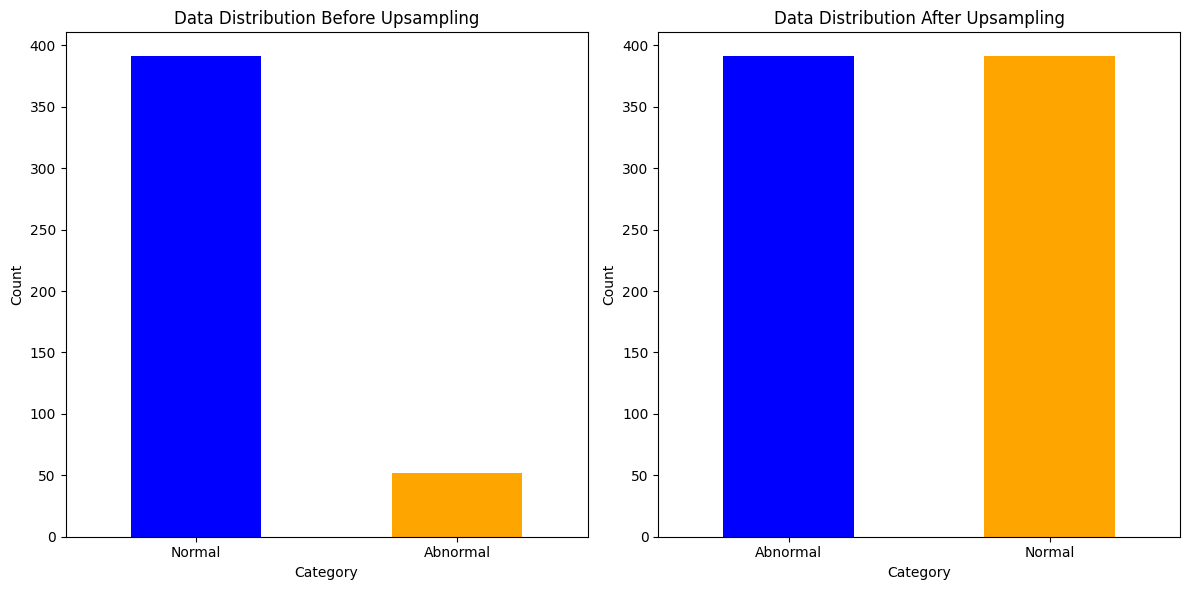

In [178]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample

# Load the original dataset
file_path = 'transformed_ppg_data.csv'  # Replace with the path to your original dataset
df = pd.read_csv(file_path)

# Define normal glycaemia range in mmol/L
normal_range = (4.0, 7.8)

# Categorize data into 'Normal' and 'Abnormal'
df['Category'] = df['Glycaemia'].apply(lambda x: 'Normal' if normal_range[0] <= x <= normal_range[1] else 'Abnormal')

# Count the number of instances in each category before upsampling
category_counts_before = df['Category'].value_counts()

# Separate the 'Normal' and 'Abnormal' categories
normal_df = df[df['Category'] == 'Normal']
abnormal_df = df[df['Category'] == 'Abnormal']

# Perform upsampling on the smaller category to balance the dataset
if len(normal_df) > len(abnormal_df):
    abnormal_df_upsampled = resample(abnormal_df, replace=True, n_samples=len(normal_df), random_state=42)
    balanced_df = pd.concat([normal_df, abnormal_df_upsampled])
else:
    normal_df_upsampled = resample(normal_df, replace=True, n_samples=len(abnormal_df), random_state=42)
    balanced_df = pd.concat([normal_df_upsampled, abnormal_df])

# Shuffle the balanced dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Count the number of instances in each category after upsampling
category_counts_after = balanced_df['Category'].value_counts()

# Plot the data distribution before and after upsampling
plt.figure(figsize=(12, 6))

# Before Upsampling
plt.subplot(1, 2, 1)
category_counts_before.plot(kind='bar', color=['blue', 'orange'])
plt.title('Data Distribution Before Upsampling')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)

# After Upsampling
plt.subplot(1, 2, 2)
category_counts_after.plot(kind='bar', color=['blue', 'orange'])
plt.title('Data Distribution After Upsampling')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()
